# <center> Предсказание победителя в Dota 2
<center> <img src="https://meduza.io/impro/YnJZAHUW6WHz_JQm1uRPkTql_qAhbfxt3oFJLGH7CJg/fill/980/0/ce/1/aHR0cHM6Ly9tZWR1/emEuaW8vaW1hZ2Uv/YXR0YWNobWVudHMv/aW1hZ2VzLzAwNy8x/NTcvNjk1L29yaWdp/bmFsL0tMVThLbUti/ZG5pSzlibDA0Wmlw/WXcuanBn.webp" width="700" height="700">

[Почитать подбробнее](https://meduza.io/feature/2021/10/19/rossiyskaya-komanda-vyigrala-chempionat-mira-po-dota-2-i-poluchila-18-millionov-dollarov-postoyte-otkuda-takie-dengi-neuzheli-igrat-v-dotu-tak-slozhno)

#### [Оригинальная статья](https://arxiv.org/pdf/2106.01782.pdf)
    
### Начало

Посмотрим на готовые признаки и сделаем первую посылку. 

1. [Описание данных](#Описание-данных)
2. [Описание признаков](#Описание-признаков)
3. [Наша первая модель](#Наша-первая-модель)
4. [Посылка](#Посылка)

### Первые шаги на пути в датасайенс

5. [Кросс-валидация](#Кросс-валидация)
6. [Что есть в json файлах?](#Что-есть-в-json-файлах?)
7. [Feature engineering](#Feature-engineering)

### Импорты

In [2]:
import os
import json
import pandas as pd
import datetime
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import ujson
import tqdm

from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score

from sklearn.model_selection import GridSearchCV

%matplotlib inline

In [3]:
import seaborn as sns
import catboost
import xgboost
import lightgbm
from sklearn.ensemble import (VotingClassifier, ExtraTreesClassifier)
from sklearn.preprocessing import StandardScaler

from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier)
from sklearn.neighbors import KNeighborsClassifier

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

/home/yuliya/.cache/pypoetry/virtualenvs/bi-ml-2021-NEzni0Ey-py3.10/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [4]:
SEED = 10801
sns.set_style(style="whitegrid")
plt.rcParams["figure.figsize"] = 12, 8
warnings.filterwarnings("ignore")

## <left>Описание данных

Файлы:

- `sample_submission.csv`: пример файла-посылки
- `train_raw_data.jsonl`, `test_raw_data.jsonl`: "сырые" данные 
- `train_data.csv`, `test_data.csv`: признаки, созданные авторами
- `train_targets.csv`: результаты тренировочных игр

## <left>Описание признаков
    
Набор простых признаков, описывающих игроков и команды в целом

In [5]:
PATH_TO_DATA = "../data/"

df_train_features = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                             "train_data.csv"), 
                                    index_col="match_id_hash")
df_train_targets = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                            "train_targets.csv"), 
                                   index_col="match_id_hash")

In [6]:
df_train_features.shape

(31698, 245)

In [7]:
df_train_features.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0.000000,0,0,0,0,0.00,0,0,0,0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0.000000,0,0,0,0,0.00,0,0,0,0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0.000000,0,0,0,0,0.00,0,0,0,0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,8.264696,0,0,3,0,0.25,0,0,3,0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,15.762911,3,1,0,1,0.50,0,0,3,0


Имеем ~32 тысячи наблюдений, каждое из которых характеризуется уникальным `match_id_hash` (захэшированное id матча), и 245 признаков. `game_time` показывает момент времени, в который получены эти данные. То есть по сути это не длительность самого матча, а например, его середина, таким образом, в итоге мы сможем получить модель, которая будет предсказывать вероятность победы каждой из команд в течение матча (хорошо подходит для букмекеров).

Нас интересует поле `radiant_win` (так называется одна из команд, вторая - dire). Остальные колоки здесь по сути получены из "будущего" и есть только для тренировочных данных, поэтому на них можно просто посмотреть).

In [8]:
df_train_targets.head()

,game_time,radiant_win,duration,time_remaining,next_roshan_team
match_id_hash,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,True,1154,496,NaN
6db558535151ea18ca70a6892197db41,21,True,1503,1482,Radiant
19c39fe2af2b547e48708ca005c6ae74,160,False,2063,1903,NaN
c96d629dc0c39f0c616d1949938a6ba6,1016,True,2147,1131,Radiant
156c88bff4e9c4668b0f53df3d870f1b,582,False,1927,1345,Dire


## <left>Наша первая модель

In [8]:
X = df_train_features.values
y = df_train_targets["radiant_win"].values.astype("int8")

In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size=0.3, 
                                                      random_state=SEED)

In [10]:
np.unique(y, return_counts=True)

(array([0, 1], dtype=int8), array([15028, 16670]))

#### Обучим случайный лес

In [12]:
%%time
rf_model = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
rf_model.fit(X_train, y_train)

CPU times: user 59.9 s, sys: 1.07 s, total: 1min
Wall time: 11.2 s


RandomForestClassifier(max_depth=7, n_estimators=300, n_jobs=-1,
                       random_state=10801)

#### Сделаем предсказания и оценим качество на отложенной части данных

In [13]:
y_pred = rf_model.predict_proba(X_valid)[:, 1]

In [14]:
valid_score = roc_auc_score(y_valid, y_pred)
print("ROC-AUC score на отложенной части:", valid_score)

ROC-AUC score на отложенной части: 0.7754387258058622


Посмотрим на accuracy:

In [15]:
valid_accuracy = accuracy_score(y_valid, y_pred > 0.5)
print("Accuracy score (p > 0.5) на отложенной части:", valid_accuracy)

Accuracy score (p > 0.5) на отложенной части: 0.6885383806519453


## <left>Посылка

In [74]:
df_test_features = pd.read_csv(os.path.join("../data/test_data.csv"), 
                                            index_col="match_id_hash")

X_test = df_test_features.values
y_test_pred = rf_model.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_test_features.index)

NameError: name 'rf_model' is not defined

In [17]:
submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(''.join(['../data/', submission_filename]))
print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2022-04-02_15-57-21.csv


## <left>Кросс-валидация

Во многих случаях кросс-валидация оказывается лучше простого разбиения на test и train. Воспользуемся `ShuffleSplit` чтобы создать 5 70%/30% наборов данных.

In [18]:
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)

In [19]:
%%time
rf_model = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
cv_scores_rf = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc")

CPU times: user 12.3 s, sys: 1.14 s, total: 13.5 s
Wall time: 51.1 s


In [20]:
cv_scores_rf

array([0.77543873, 0.77343884, 0.76649967, 0.7722681 , 0.77246001])

In [21]:
print(f"Среднее значение ROC-AUC на кросс-валидации: {cv_scores_rf.mean()}")

Среднее значение ROC-AUC на кросс-валидации: 0.7720210676055513


## <left>Что есть в json файлах?

Описание сырых данных можно найти в `train_matches.jsonl` и `test_matches.jsonl`. Каждый файл содержит одну запись для каждого матча в [JSON](https://en.wikipedia.org/wiki/JSON) формате. Его легко превратить в питоновский объект при помощи метода `json.loads`.

In [22]:
with open(os.path.join(PATH_TO_DATA, "train_raw_data.jsonl")) as fin:
    # прочтем 419 строк
    for i in range(419):
        line = fin.readline()
    
    # переведем JSON в питоновский словарь 
    match = json.loads(line)

In [23]:
player = match["players"][9]
player["kills"], player["deaths"], player["assists"]

(0, 5, 5)

KDA - может быть неплохим признаком, этот показатель считается как:
    
<center>$KDA = \frac{K + A}{D}$

Информация о количестве использованных способностей:

In [24]:
player["ability_uses"]

{'treant_living_armor': 52, 'treant_leech_seed': 5, 'treant_overgrowth': 5}

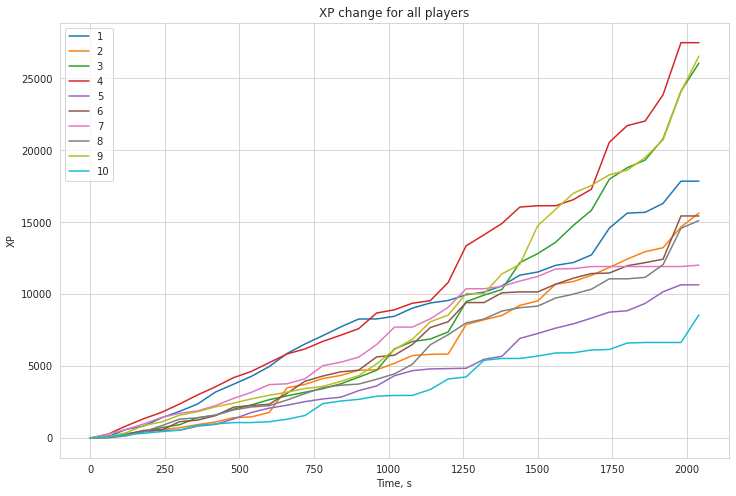

In [25]:
for i, player in enumerate(match["players"]):
    plt.plot(player["times"], player["xp_t"], label=str(i+1))

plt.legend()
plt.xlabel("Time, s")
plt.ylabel("XP")
plt.title("XP change for all players");

#### Сделаем чтение файла с сырыми данными и добавление новых признаков удобным

В этот раз для чтение `json` файлов лучше использовать библиотеку `ujson`, иначе все будет слишком долго :(

In [11]:
try:
    import ujson as json
except ModuleNotFoundError:
    import json
    print ("Подумайте об установке ujson, чтобы работать с JSON объектами быстрее")
    
try:
    from tqdm.notebook import tqdm
except ModuleNotFoundError:
    tqdm_notebook = lambda x: x
    print ("Подумайте об установке tqdm, чтобы следить за прогрессом")

    
def read_matches(matches_file, total_matches=31698, n_matches_to_read=None):
    """
    Аргуент
    -------
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Возвращает записи о каждом матче
    """
    
    if n_matches_to_read is None:
        n_matches_to_read = total_matches
        
    c = 0
    with open(matches_file) as fin:
        for line in tqdm(fin, total=total_matches):
            if c >= n_matches_to_read:
                break
            else:
                c += 1
                yield json.loads(line)

#### Чтение данных в цикле

Чтение всех данных занимает 1-2 минуты, поэтому для начала можно попробовать следующее:

1. Читать 10-50 игр
2. Написать код для работы с этими JSON объектами
3. Убедиться, что все работает
4. Запустить код на всем датасете
5. Сохранить результат в `pickle` файл, чтобы в следующий раз не переделывать все заново

## <left>Feature engineering

Напишем функцию, которая поможет нам легче добавлять новые признаки.

In [12]:
def add_new_features(df_features, matches_file):
    """
    Аргуенты
    -------
    df_features: таблица с данными
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Добавляет новые признаки в таблицу
    """
    
    for match in read_matches(matches_file):
        match_id_hash = match['match_id_hash']

        # Посчитаем количество разрушенных вышек обеими командами
        radiant_tower_kills = 0
        dire_tower_kills = 0
        for objective in match["objectives"]:
            if objective["type"] == "CHAT_MESSAGE_TOWER_KILL":
                if objective["team"] == 2:
                    radiant_tower_kills += 1
                if objective["team"] == 3:
                    dire_tower_kills += 1

        df_features.loc[match_id_hash, "radiant_tower_kills"] = radiant_tower_kills
        df_features.loc[match_id_hash, "dire_tower_kills"] = dire_tower_kills
        df_features.loc[match_id_hash, "diff_tower_kills"] = radiant_tower_kills - dire_tower_kills
        
        # ... (/¯◡ ‿ ◡)/¯☆*:・ﾟ добавляем новые признаки ...

In [28]:
# Скопируем таблицу с признаками
df_train_features_extended = df_train_features.copy()

# Добавим новые
add_new_features(df_train_features_extended, 
                 os.path.join(PATH_TO_DATA, 
                              "train_raw_data.jsonl"))

  0%|          | 0/31698 [00:00<?, ?it/s]

In [29]:
df_train_features_extended.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed,radiant_tower_kills,dire_tower_kills,diff_tower_kills
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0,0,0.00,0,0,0,0,2.0,0.0,2.0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0,0,0.00,0,0,0,0,0.0,0.0,0.0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0,0,0.00,0,0,0,0,0.0,0.0,0.0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,3,0,0.25,0,0,3,0,0.0,0.0,0.0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,0,1,0.50,0,0,3,0,0.0,1.0,-1.0


In [30]:
%%time
cv_scores_base = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
cv_scores_extended = cross_val_score(rf_model, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

CPU times: user 87.9 ms, sys: 107 ms, total: 195 ms
Wall time: 1min 17s


In [31]:
print(f"ROC-AUC на кросс-валидации для базовых признаков: {cv_scores_base.mean()}")
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_extended.mean()}")

ROC-AUC на кросс-валидации для базовых признаков: 0.7720210676055513
ROC-AUC на кросс-валидации для новых признаков: 0.778796825263235


Видно, что случайный лес стал работать немного лучше при добавлении новых признаков. A еще нужно, наверное, как-то по-умному закодировать категориальные признаки.

Дальше дело за малым. Добавляйте новые признаки, пробуйте другие методы, которые мы изучили, а также что-то интересное, что мы не прошли. Удачи!

# Прочитаем побольше всего

In [13]:
def add_new_features(df_features, matches_file, total_matches=31698):
    """
    Аргуенты
    -------
    df_features: таблица с данными
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Добавляет новые признаки в таблицу
    """
    
    for match in read_matches(matches_file, total_matches=total_matches):
        match_id_hash = match['match_id_hash']

        # Посчитаем количество разрушенных вышек обеими командами
        radiant_tower_kills = 0
        dire_tower_kills = 0
        # и другие данные
        first_blood = 0
        aegis_stolen_radiant, aegis_stolen_dire = 0, 0
        aegis_denied_radiant, aegis_denied_dire = 0, 0
        radiant_roshan_kills, dire_roshan_kills = 0, 0
        barracks_kill = 0
        dire_ability_uses = 0
        rad_ability_uses = 0
        
        for objective in match["objectives"]:
            if objective["type"] == "CHAT_MESSAGE_TOWER_KILL":
                if objective["team"] == 2:
                    radiant_tower_kills += 1
                if objective["team"] == 3:
                    dire_tower_kills += 1
            if objective["type"] == "CHAT_MESSAGE_ROSHAN_KILL":
                if objective["team"] == 2:
                    radiant_roshan_kills += 1
                if objective["team"] == 3:
                    dire_roshan_kills += 1
                    
            if objective["type"] == "CHAT_MESSAGE_BARRACKS_KILL":
                barracks_kill += 1
                    
            if objective["type"] == "CHAT_MESSAGE_FIRSTBLOOD":
                if objective["player_slot"] < 6:
                    first_blood = 1
                    
            if objective["type"] == "CHAT_MESSAGE_AEGIS_STOLEN":
                if objective["player_slot"] < 6:
                    aegis_stolen_radiant += 1
                if objective["player_slot"] > 50:
                    aegis_stolen_dire += 1
            
            if objective["type"] == "CHAT_MESSAGE_DENIED_AEGIS":
                if objective["player_slot"] < 6:
                    aegis_denied_radiant += 1
                if objective["player_slot"] > 50:
                    aegis_denied_dire += 1
                    
                
        df_features.loc[match_id_hash, "radiant_tower_kills"] = radiant_tower_kills
        df_features.loc[match_id_hash, "dire_tower_kills"] = dire_tower_kills
        df_features.loc[match_id_hash, "diff_tower_kills"] = radiant_tower_kills - dire_tower_kills
        
        df_features.loc[match_id_hash, "radiant_roshan_kills"] = radiant_roshan_kills
        df_features.loc[match_id_hash, "dire_roshan_kills"] = dire_roshan_kills
        df_features.loc[match_id_hash, "diff_roshan_kills"] = radiant_roshan_kills - dire_roshan_kills
        
        df_features.loc[match_id_hash, "first_blood"] = first_blood
        df_features.loc[match_id_hash, "barracks_kill"] = barracks_kill       
        
        df_features.loc[match_id_hash, "aegis_stolen_diff"] = aegis_stolen_radiant - aegis_stolen_dire
        df_features.loc[match_id_hash, "aegis_stolen_radiant"] = aegis_stolen_radiant
        df_features.loc[match_id_hash, "aegis_stolen_dire"] = aegis_stolen_dire
            
        df_features.loc[match_id_hash, "aegis_denied_diff"] = aegis_denied_radiant - aegis_denied_dire
        df_features.loc[match_id_hash, "aegis_denied_radiant"] = aegis_denied_radiant
        df_features.loc[match_id_hash, "aegis_denied_dire"] = aegis_denied_dire
        
        for player in match["players"]:
            if player['player_slot'] > 90:
                for i in player["ability_uses"].values():
                    dire_ability_uses += i
            else:
                for i in player["ability_uses"].values():
                    rad_ability_uses += i
        
        df_features.loc[match_id_hash, "rad_ability_uses"] = rad_ability_uses
        df_features.loc[match_id_hash, "dire_ability_uses"] = dire_ability_uses 
        
        
        
        # ... (/¯◡ ‿ ◡)/¯☆*:・ﾟ добавляем новые признаки ...

In [14]:
# Скопируем таблицу с признаками
df_train_features_extended = df_train_features.copy()

# Добавим новые
add_new_features(df_train_features_extended, 
                 os.path.join(PATH_TO_DATA, 
                              "train_raw_data.jsonl"))

  0%|          | 0/31698 [00:00<?, ?it/s]

## <left>Feature engineering

In [15]:
train = df_train_features_extended.copy()

<AxesSubplot:>

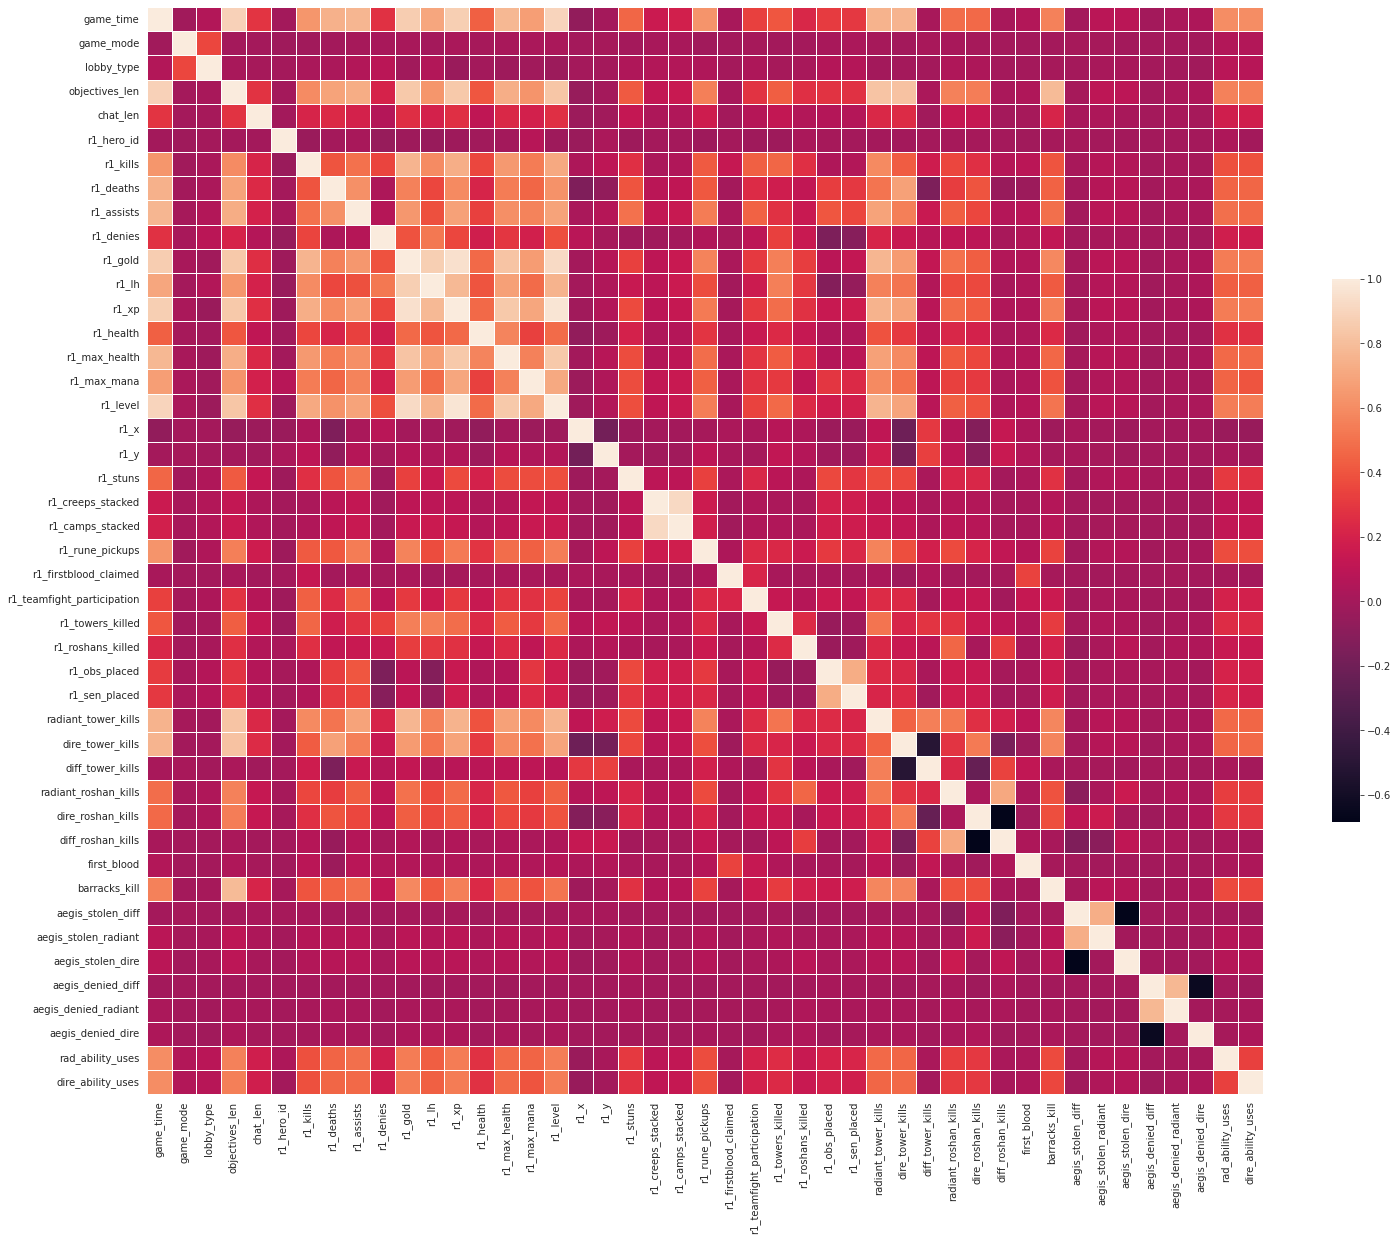

In [35]:
plt.figure(figsize=(25, 20))

sns.heatmap(train[['game_time', 'game_mode', 'lobby_type', 'objectives_len', 'chat_len', 
                                        'r1_hero_id', 'r1_kills', 'r1_deaths', 'r1_assists', 'r1_denies', 'r1_gold', 
                                        'r1_lh', 'r1_xp', 'r1_health', 'r1_max_health', 'r1_max_mana', 'r1_level', 
                                        'r1_x', 'r1_y', 'r1_stuns', 'r1_creeps_stacked', 'r1_camps_stacked', 
                                        'r1_rune_pickups', 'r1_firstblood_claimed', 'r1_teamfight_participation', 
                                        'r1_towers_killed', 'r1_roshans_killed', 'r1_obs_placed', 'r1_sen_placed',
                                        'radiant_tower_kills', 'dire_tower_kills', 'diff_tower_kills', 'radiant_roshan_kills', 
                                        'dire_roshan_kills', 'diff_roshan_kills', 'first_blood', 'barracks_kill', 
                                        'aegis_stolen_diff', 'aegis_stolen_radiant', 'aegis_stolen_dire', 'aegis_denied_diff', 
                                        'aegis_denied_radiant', 'aegis_denied_dire', 'rad_ability_uses', 
                                        'dire_ability_uses'
                                       ]].corr(),
            linewidths=0.5, 
            cbar_kws={"shrink": 0.5})

In [16]:
for i in range(1, 6):    
    train[f'd{i}_KDA'] = (train[f'd{i}_kills'] + train[f'd{i}_assists'] + 2) / (train[f'd{i}_deaths'] + 1)
    train[f'r{i}_KDA'] = (train[f'r{i}_kills'] + train[f'r{i}_assists'] + 2) / (train[f'r{i}_deaths'] + 1)
    
    train = train.drop([f'd{i}_kills', f'd{i}_assists', f'd{i}_deaths',
                        f'r{i}_kills', f'r{i}_assists', f'r{i}_deaths'],
                      axis=1)

In [17]:
for i in range(1, 6):
    train = train.drop([f'd{i}_roshans_killed',
                        f'r{i}_roshans_killed'],
                      axis=1)

<AxesSubplot:>

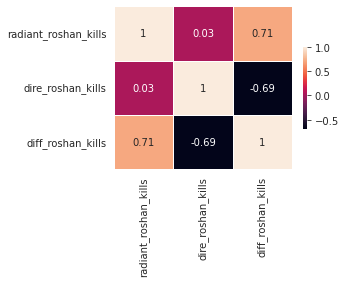

In [18]:
plt.figure(figsize=(4, 3))
sns.heatmap(train[['radiant_roshan_kills', 'dire_roshan_kills', 'diff_roshan_kills']].corr(),
            linewidths=0.5, 
            annot=True,
            cbar_kws={"shrink": 0.5})

In [19]:
for i in range(1, 6):
    train = train.drop([f'd{i}_level',
                        f'r{i}_level'],
                      axis=1)

In [20]:
train['r_creeps_stacked'] = 0
train['d_creeps_stacked'] = 0
train['r_camps_stacked'] = 0
train['d_camps_stacked'] = 0


for i in range(1, 6):
    train['r_creeps_stacked'] += train[f'r{i}_creeps_stacked'] 
    train['d_creeps_stacked'] += train[f'd{i}_creeps_stacked'] 
    
    train['r_camps_stacked'] += train[f'r{i}_camps_stacked'] 
    train['d_camps_stacked'] += train[f'd{i}_camps_stacked'] 
    
    train = train.drop([f'r{i}_creeps_stacked', f'd{i}_creeps_stacked',
                        f'r{i}_camps_stacked', f'd{i}_camps_stacked'],
                      axis=1)

In [21]:
train['r_lh'] = 0
train['d_lh'] = 0


for i in range(1, 6):
    train['r_lh'] += train[f'r{i}_lh'] 
    train['d_lh'] += train[f'd{i}_lh']
    
    train = train.drop([f'r{i}_lh',
                        f'd{i}_lh'],
                      axis=1)

In [22]:
train['rat_lh'] = (train['r_lh'] + 1) / (train['d_lh'] + 1)

train = train.drop(['r_lh',
                    'd_lh'],
                    axis=1)

In [23]:
train['rat_camps_stacked'] = (train['r_creeps_stacked'] + 1) / (train['d_creeps_stacked'] + 1)
train['rat_creeps_stacked'] = (train['r_camps_stacked'] + 1) / (train['d_camps_stacked'] + 1)

train = train.drop(['d_creeps_stacked', 'r_creeps_stacked',
                    'd_camps_stacked', 'r_camps_stacked'],
                    axis=1)

In [24]:
train['d_gold'] = 0
train['r_gold'] = 0

for i in range(1, 6):
    train['d_gold'] += train[f'd{i}_gold'] 
    train['r_gold'] += train[f'r{i}_gold'] 
    
    train = train.drop([f'r{i}_gold',
                        f'd{i}_gold',],
                      axis=1)

In [25]:
train['diff_gold'] = train['r_gold'] / train['d_gold']

train = train.drop(['d_gold', 
                    'r_gold'],
                    axis=1)

In [26]:
train['d_xp'] = 0
train['r_xp'] = 0

for i in range(1, 6):
    train['r_xp'] += train[f'r{i}_xp'] 
    train['d_xp'] += train[f'd{i}_xp'] 
    
    train = train.drop([f'r{i}_xp',
                        f'd{i}_xp',],
                      axis=1)
    
train['diff_xp'] = (train['r_xp'] + 1) / (train['d_xp'] + 1)

train = train.drop(['d_xp', 
                    'r_xp'],
                    axis=1)

In [27]:
# до этого было Score: 0.82640

In [28]:
# id hero to hero win rate

id_hero = set(list(train['r1_hero_id']))

new_train = train.copy()
new_train['win'] = y

win_rate_for_hero = dict()

for index, row in train.iterrows():
    for i in range(1, 6):
        try:
            win_rate_for_hero[row[f'r{i}_hero_id']] += new_train.loc[index, 'win']

        except KeyError:
            win_rate_for_hero[row[f'r{i}_hero_id']] = new_train.loc[index, 'win']
            
        try:
            win_rate_for_hero[row[f'd{i}_hero_id']] += new_train.loc[index, 'win']

        except KeyError:
            win_rate_for_hero[row[f'd{i}_hero_id']] = new_train.loc[index, 'win']
            
for h_id in win_rate_for_hero:
    win_rate_for_hero[h_id] = win_rate_for_hero[h_id] / new_train.shape[0]
    
for index, row in new_train.iterrows():
    for i in range(1, 6):
        train.loc[index, f"r{i}h_win_rate"] = win_rate_for_hero[row[f"r{i}_hero_id"]]
        train.loc[index, f"d{i}h_win_rate"] = win_rate_for_hero[row[f"d{i}_hero_id"]]
    
for i in range(1, 6):
    train = train.drop([f"r{i}_hero_id", f"d{i}_hero_id"], axis=1)

In [29]:
# после этого скор =  0.82628

In [30]:
train['r_max_mana'] = 0
train['d_max_mana'] = 0

for i in range(1, 6):
    train['r_max_mana'] += train[f'r{i}_max_mana']
    train['d_max_mana'] += train[f'd{i}_max_mana']
    
    train = train.drop([f'r{i}_max_mana',
                        f'd{i}_max_mana'],
                      axis=1)
    
train['diff_max_mana'] = (train['r_max_mana'] + 1) / (train['d_max_mana'] + 1)

train = train.drop(['r_max_mana', 'd_max_mana'], axis=1)

In [31]:
train['r_first_blood'] = 0
train['d_first_blood'] = 0

for i in range(1, 6):
    train['r_first_blood'] += train[f'r{i}_firstblood_claimed']
    train['d_first_blood'] += train[f'd{i}_firstblood_claimed']
    
    train = train.drop([f'r{i}_firstblood_claimed',
                        f'd{i}_firstblood_claimed',],
                      axis=1)

In [32]:
train['first_blood'] = train['r_first_blood'] - train['d_first_blood']

train = train.drop(['r_first_blood', 'd_first_blood'], axis=1)

In [33]:
# 0.82668

In [34]:
train['rat_creeps_a_camps_stacked'] = train['rat_camps_stacked'] + train['rat_creeps_stacked']

train = train.drop(['rat_camps_stacked', 'rat_creeps_stacked'], axis=1)

train = train.drop(['objectives_len'], axis=1)

In [35]:
# 0.82784

<AxesSubplot:>

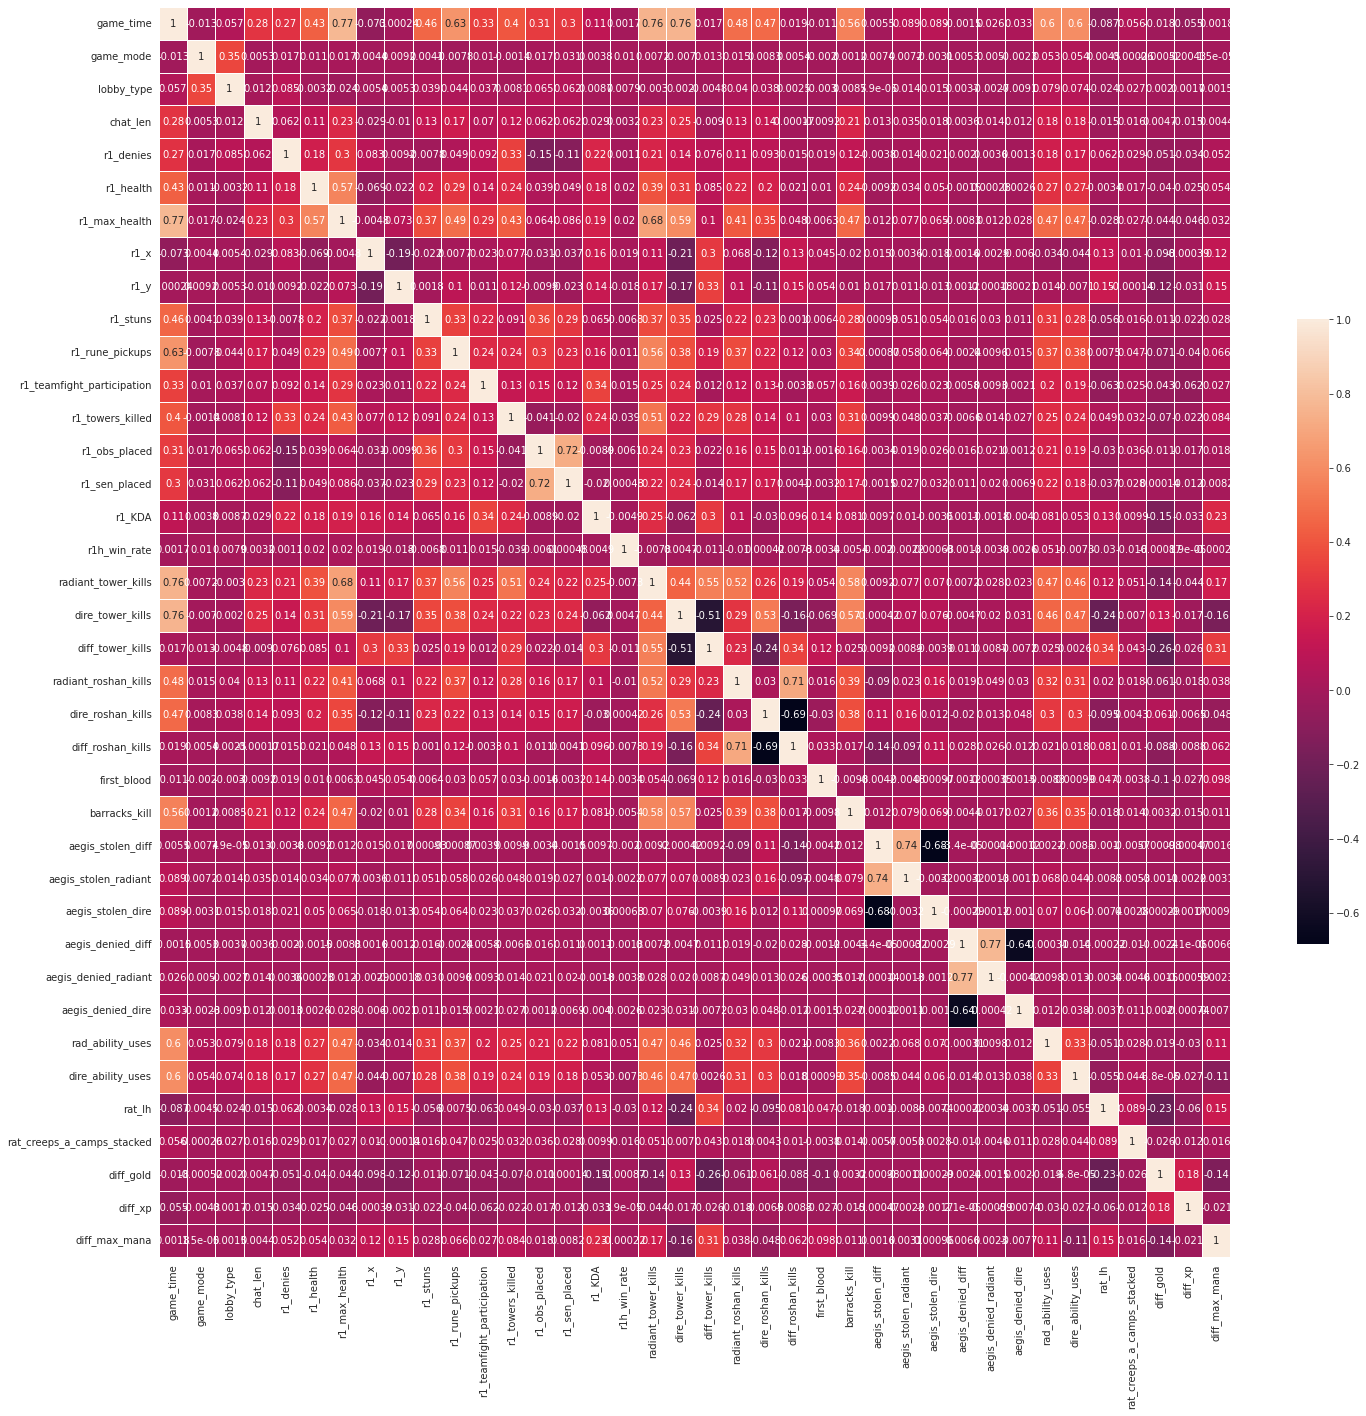

In [56]:
plt.figure(figsize=(24, 23))
sns.heatmap(train[['game_time', 'game_mode', 'lobby_type', 'chat_len', 
                   
                   'r1_denies', 'r1_health', 'r1_max_health', 'r1_x', 'r1_y', 'r1_stuns', 
                   'r1_rune_pickups', 'r1_teamfight_participation', 'r1_towers_killed', 
                   'r1_obs_placed', 'r1_sen_placed', 'r1_KDA', 'r1h_win_rate',
                   
                   'radiant_tower_kills', 'dire_tower_kills', 'diff_tower_kills', 
                   'radiant_roshan_kills', 'dire_roshan_kills', 'diff_roshan_kills', 
                   'first_blood', 'barracks_kill', 'aegis_stolen_diff', 'aegis_stolen_radiant', 
                   'aegis_stolen_dire', 'aegis_denied_diff', 'aegis_denied_radiant', 
                   'aegis_denied_dire', 'rad_ability_uses', 'dire_ability_uses',
                   'rat_lh', 'rat_creeps_a_camps_stacked', 
                   'diff_gold', 'diff_xp', 'diff_max_mana',                    
                  ]].corr(),
            linewidths=0.5, 
            annot=True,
            cbar_kws={"shrink": 0.5})

# Подготовим данные теста

In [36]:
df_test_features = pd.read_csv(os.path.join('../data', "test_data.csv"), 
                                            index_col="match_id_hash")
# Скопируем таблицу с признаками
test = df_test_features.copy()

In [37]:
# Добавим новые
add_new_features(test, 
                 os.path.join('../data', 
                              "test_raw_data.jsonl"),
                total_matches = 7977)

  0%|          | 0/7977 [00:00<?, ?it/s]

In [38]:
df_test = test.copy()

In [39]:
for i in range(1, 6):    
    df_test[f'd{i}_KDA'] = (df_test[f'd{i}_kills'] + df_test[f'd{i}_assists'] + 2) / (df_test[f'd{i}_deaths'] + 1)
    df_test[f'r{i}_KDA'] = (df_test[f'r{i}_kills'] + df_test[f'r{i}_assists'] + 2) / (df_test[f'r{i}_deaths'] + 1)
    
    df_test = df_test.drop([f'd{i}_kills', f'd{i}_assists', f'd{i}_deaths',
                            f'r{i}_kills', f'r{i}_assists', f'r{i}_deaths'],
                            axis=1)

In [40]:
for i in range(1, 6):
    df_test = df_test.drop([f'd{i}_level', f'r{i}_level',
                            f'd{i}_roshans_killed', f'r{i}_roshans_killed'],
                            axis=1)

In [41]:
df_test['r_creeps_stacked'] = 0
df_test['d_creeps_stacked'] = 0
df_test['r_camps_stacked'] = 0
df_test['d_camps_stacked'] = 0


for i in range(1, 6):
    df_test['r_creeps_stacked'] += df_test[f'r{i}_creeps_stacked'] 
    df_test['d_creeps_stacked'] += df_test[f'd{i}_creeps_stacked'] 
    
    df_test['r_camps_stacked'] += df_test[f'r{i}_camps_stacked'] 
    df_test['d_camps_stacked'] += df_test[f'd{i}_camps_stacked'] 
    
    df_test = df_test.drop([f'r{i}_creeps_stacked', f'd{i}_creeps_stacked',
                        f'r{i}_camps_stacked', f'd{i}_camps_stacked'],
                      axis=1)

In [42]:
df_test['r_lh'] = 0
df_test['d_lh'] = 0


for i in range(1, 6):
    df_test['r_lh'] += df_test[f'r{i}_lh'] 
    df_test['d_lh'] += df_test[f'd{i}_lh']
    
    df_test = df_test.drop([f'r{i}_lh',
                            f'd{i}_lh'],
                              axis=1)

In [43]:
df_test['rat_lh'] = (df_test['r_lh'] + 1) / (df_test['d_lh'] + 1)

df_test = df_test.drop(['r_lh', 'd_lh'],
                        axis=1)

In [44]:
df_test['rat_camps_stacked'] = (df_test['r_creeps_stacked'] + 1) / (df_test['d_creeps_stacked'] + 1)
df_test['rat_creeps_stacked'] = (df_test['r_camps_stacked'] + 1) / (df_test['d_camps_stacked'] + 1)

df_test = df_test.drop(['d_creeps_stacked', 'r_creeps_stacked',
                        'd_camps_stacked', 'r_camps_stacked'],
                        axis=1)

In [45]:
df_test['d_gold'] = 0
df_test['r_gold'] = 0

for i in range(1, 6):
    df_test['r_gold'] += df_test[f'r{i}_gold'] 
    df_test['d_gold'] += df_test[f'd{i}_gold'] 
    
    df_test = df_test.drop([f'r{i}_gold',
                            f'd{i}_gold',],
                            axis=1)

In [46]:
df_test['diff_gold'] = df_test['r_gold'] / df_test['d_gold']

df_test = df_test.drop(['d_gold', 
                        'r_gold'],
                        axis=1)

In [47]:
df_test['d_xp'] = 0
df_test['r_xp'] = 0

for i in range(1, 6):
    df_test['r_xp'] += df_test[f'r{i}_xp'] 
    df_test['d_xp'] += df_test[f'd{i}_xp'] 
    
    df_test = df_test.drop([f'r{i}_xp',
                        f'd{i}_xp',],
                      axis=1)


In [48]:
df_test['diff_xp'] = (df_test['r_xp'] + 1) / (df_test['d_xp'] + 1)

df_test = df_test.drop(['d_xp', 
                        'r_xp'],
                        axis=1)

In [49]:
# 8.2

In [50]:
# id hero to hero win rate
# df_test = test.copy()

for index, row in df_test.iterrows():
    for i in range(1, 6):
        df_test.loc[index, f"r{i}h_win_rate"] = win_rate_for_hero[row[f"r{i}_hero_id"]]
        df_test.loc[index, f"d{i}h_win_rate"] = win_rate_for_hero[row[f"d{i}_hero_id"]]
    
for i in range(1, 6):
    df_test = df_test.drop([f"r{i}_hero_id", f"d{i}_hero_id"], axis=1)

In [51]:
#  0.82628

In [52]:
df_test['r_first_blood'] = 0
df_test['d_first_blood'] = 0

for i in range(1, 6):
    df_test['r_first_blood'] += df_test[f'r{i}_firstblood_claimed']
    df_test['d_first_blood'] += df_test[f'd{i}_firstblood_claimed']
    
    df_test = df_test.drop([f'r{i}_firstblood_claimed',
                        f'd{i}_firstblood_claimed',],
                      axis=1)

In [53]:
df_test['first_blood'] = df_test['r_first_blood'] - df_test['d_first_blood']

df_test = df_test.drop(['r_first_blood', 'd_first_blood'], axis=1)

In [54]:
df_test['r_max_mana'] = 0
df_test['d_max_mana'] = 0

for i in range(1, 6):
    df_test['r_max_mana'] += df_test[f'r{i}_max_mana']
    df_test['d_max_mana'] += df_test[f'd{i}_max_mana']
    
    df_test = df_test.drop([f'r{i}_max_mana',
                        f'd{i}_max_mana'],
                      axis=1)
    
df_test['diff_max_mana'] = (df_test['r_max_mana'] + 1) / (df_test['d_max_mana'] + 1)

df_test = df_test.drop(['r_max_mana', 'd_max_mana'], axis=1)

In [55]:
# 0.82668

In [56]:
df_test['rat_creeps_a_camps_stacked'] = df_test['rat_camps_stacked'] + df_test['rat_creeps_stacked']

df_test = df_test.drop(['rat_camps_stacked', 'rat_creeps_stacked'], axis=1)

df_test = df_test.drop(['objectives_len'], axis=1)

In [57]:
# 0.82784

# Scaler

In [58]:
y = df_train_targets["radiant_win"].values.astype("int8")

X_train, X_valid, y_train, y_valid = train_test_split(train, y, 
                                                      test_size=0.3, 
                                                      random_state=SEED)

In [59]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)

In [60]:
X_b_train, X_s_train, y_b_train, y_s_train = train_test_split(X_train, y_train, 
                                                      test_size=0.2, 
                                                      random_state=SEED)

# Тест получившегося

In [87]:
%%time

cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)

rf_model = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
cv_scores_rf = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc")

print(f"Среднее значение ROC-AUC на кросс-валидации: {cv_scores_rf.mean()}")

Среднее значение ROC-AUC на кросс-валидации: 0.7778841417472704
CPU times: user 11 s, sys: 1.36 s, total: 12.3 s
Wall time: 41.9 s


In [190]:
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=7, n_estimators=300, n_jobs=-1,
                       random_state=10801)

In [191]:
y_pred = rf_model.predict_proba(X_valid)[:, 1]

valid_score = roc_auc_score(y_valid, y_pred)
print("ROC-AUC score на отложенной части:", valid_score)

valid_accuracy = accuracy_score(y_valid, y_pred > 0.5)
print("Accuracy score (p > 0.5) на отложенной части:", valid_accuracy)

ROC-AUC score на отложенной части: 0.7779986840532014
Accuracy score (p > 0.5) на отложенной части: 0.6982124079915878


In [192]:
parameters = {'criterion': ['gini'], 
              'n_estimators': range(50, 550, 50),
              'max_depth': range(2, 19, 2),
              'min_samples_leaf' : range(2, 6, 2)}

cls_m = RandomForestClassifier(random_state=SEED)
grid_search_cv_cls = GridSearchCV(cls_m, parameters, cv=3, n_jobs=-1, scoring="roc_auc")

grid_search_cv_cls.fit(X_train, y_train)

cls_dgs_best = grid_search_cv_cls.best_estimator_

print(grid_search_cv_cls.best_params_)
print(grid_search_cv_cls.best_estimator_)

{'criterion': 'gini', 'max_depth': 16, 'min_samples_leaf': 4, 'n_estimators': 500}
RandomForestClassifier(max_depth=16, min_samples_leaf=4, n_estimators=500,
                       random_state=10801)


In [197]:
cls_best = RandomForestClassifier(max_depth=16, min_samples_leaf=4,
                                  n_estimators=400, n_jobs=-1, random_state=SEED)

cls_best.fit(X_train, y_train)

y_pred = cls_best.predict_proba(X_valid)[:, 1]

valid_score = roc_auc_score(y_valid, y_pred)
print("ROC-AUC score на отложенной части:", valid_score)

valid_accuracy = accuracy_score(y_valid, y_pred > 0.5)
print("Accuracy score (p > 0.5) на отложенной части:", valid_accuracy)

ROC-AUC score на отложенной части: 0.7935548587317451
Accuracy score (p > 0.5) на отложенной части: 0.7093585699263932


# Другие модели

## 1. LR

In [183]:
lr = LogisticRegression(solver='liblinear', max_iter=10000)

lr.fit(X_train, y_train)
scores = cross_val_score(lr, X_train, y_train, cv=3, scoring="roc_auc")
print(f"{lr.__class__.__name__}: {scores.mean()}")

y_pred = lr.predict_proba(X_valid)[:, 1]

valid_score = roc_auc_score(y_valid, y_pred)
print("ROC-AUC score на отложенной части:", valid_score)

valid_accuracy = accuracy_score(y_valid, y_pred > 0.5)
print("Accuracy score (p > 0.5) на отложенной части:", valid_accuracy)

LogisticRegression: 0.8069993048250255
ROC-AUC score на отложенной части: 0.8058114094609797
Accuracy score (p > 0.5) на отложенной части: 0.7192429022082019


Text(15.0, 0.5, 'Truth')

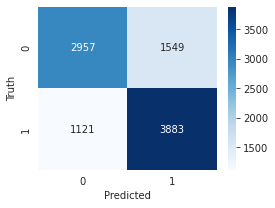

In [184]:
y_pred = lr.predict(X_valid)

conf_mat = confusion_matrix(y_true=y_valid, y_pred=y_pred)


plt.figure(figsize=(4,3))
sns.heatmap(conf_mat, cmap=plt.cm.Blues, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [97]:
parameters = {'penalty': ['l1','l2'], 
              'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag'],
              'class_weight': ['None', 'balanced'],
              'max_iter': range(1000, 10000, 1000)}

lr = LogisticRegression(random_state=SEED)
grid_search_lr = GridSearchCV(lr, parameters, cv=3, n_jobs=-1, scoring="roc_auc")

grid_search_lr.fit(X_train, y_train)

lr_best = grid_search_lr.best_estimator_

print(grid_search_lr.best_params_)
print(grid_search_lr.best_estimator_)

/home/yuliya/.cache/pypoetry/virtualenvs/bi-ml-2021-NEzni0Ey-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/yuliya/.cache/pypoetry/virtualenvs/bi-ml-2021-NEzni0Ey-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/yuliya/.cache/pypoetry/virtualenvs/bi-ml-2021-NEzni0Ey-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/yuliya/.cache/pypoetry/virtualenvs/bi-ml-2021-NEzni0Ey-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/yuliya/.cache/pypoetry/virtualenvs/bi-ml-2021-NEzni0Ey-py3.10/lib/

/home/yuliya/.cache/pypoetry/virtualenvs/bi-ml-2021-NEzni0Ey-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/yuliya/.cache/pypoetry/virtualenvs/bi-ml-2021-NEzni0Ey-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/yuliya/.cache/pypoetry/virtualenvs/bi-ml-2021-NEzni0Ey-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/yuliya/.cache/pypoetry/virtualenvs/bi-ml-2021-NEzni0Ey-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/yuliya/.cache/pypoetry/virtualenvs/bi-ml-2021-NEzni0Ey-py3.10/lib/

AttributeError: 'LogisticRegression' object has no attribute 'best_params_'

In [98]:
print(grid_search_lr.best_params_)
print(grid_search_lr.best_estimator_)

{'C': 0.1, 'class_weight': 'balanced', 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}
LogisticRegression(C=0.1, class_weight='balanced', max_iter=1000, penalty='l1',
                   random_state=10801, solver='liblinear')


Text(15.0, 0.5, 'Truth')

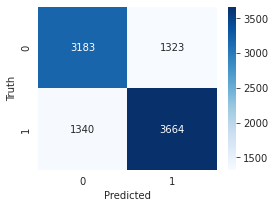

In [185]:
y_pred = lr_best.predict(X_valid)

conf_mat = confusion_matrix(y_true=y_valid, y_pred=y_pred)

plt.figure(figsize=(4,3))
sns.heatmap(conf_mat, cmap=plt.cm.Blues, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Truth')

## 2. small Voting

In [110]:
rf = RandomForestClassifier(max_depth=14, min_samples_leaf=4,
                            n_estimators=400, n_jobs=-1, random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)

base_models = [("RF", rf), 
               ("LR", lr)]

voting_soft = VotingClassifier(estimators=base_models, voting = 'soft')

In [111]:
voting_soft.fit(X_train, y_train)
scores = cross_val_score(voting_soft, X_train_scaled, y_train, cv=3, scoring="roc_auc")
print(f"{voting_soft.__class__.__name__}: {scores.mean()}")

y_pred = voting_soft.predict_proba(X_train)[:, 1]

valid_score = roc_auc_score(y_valid, y_pred)
print("ROC-AUC score на отложенной части:", valid_score)

valid_accuracy = accuracy_score(y_valid, y_pred > 0.5)
print("Accuracy score (p > 0.5) на отложенной части:", valid_accuracy)

NameError: name 'X_train_scaled' is not defined

In [ ]:
# y_pred_best

y_pred = voting_soft.predict(X_valid_scaled)

conf_mat = confusion_matrix(y_true=y_valid, y_pred=y_pred)

plt.figure(figsize=(4,3))
sns.heatmap(conf_mat, cmap=plt.cm.Blues, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

## 3. ExtraTreesClassifier

In [194]:
etc = ExtraTreesClassifier(random_state=SEED)

etc.fit(X_train, y_train)
scores = cross_val_score(etc, X_train, y_train, cv=3, scoring="roc_auc")
print(f"{etc.__class__.__name__}: {scores.mean()}")

y_pred = etc.predict_proba(X_valid)[:, 1]

valid_score = roc_auc_score(y_valid, y_pred)
print("ROC-AUC score на отложенной части:", valid_score)

valid_accuracy = accuracy_score(y_valid, y_pred > 0.5)
print("Accuracy score (p > 0.5) на отложенной части:", valid_accuracy)

ExtraTreesClassifier: 0.7785864754514696
ROC-AUC score на отложенной части: 0.7806637734641405
Accuracy score (p > 0.5) на отложенной части: 0.6962145110410095


In [195]:
parameters = {'n_estimators': range(100, 550, 50),
              'max_depth': range(2, 19, 2),
              'min_samples_leaf' : range(2, 6, 2),
              'bootstrap': ['True', 'False']}

etc = ExtraTreesClassifier(random_state=SEED, n_jobs=-1)
grid_search_etc = GridSearchCV(etc, parameters, cv=3, n_jobs=-1, scoring="roc_auc")

grid_search_etc.fit(X_train, y_train)

etc_best = grid_search_etc.best_estimator_

print(grid_search_etc.best_params_)
print(grid_search_etc.best_estimator_)

{'bootstrap': 'True', 'max_depth': 18, 'min_samples_leaf': 2, 'n_estimators': 500}
ExtraTreesClassifier(bootstrap='True', max_depth=18, min_samples_leaf=2,
                     n_estimators=500, n_jobs=-1, random_state=10801)


Text(15.0, 0.5, 'Truth')

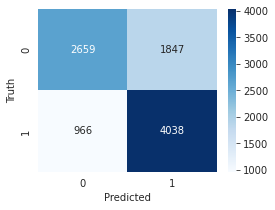

In [196]:
y_pred = etc_best.predict(X_valid)

conf_mat = confusion_matrix(y_true=y_valid, y_pred=y_pred)

plt.figure(figsize=(4,3))
sns.heatmap(conf_mat, cmap=plt.cm.Blues, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Truth')

## 4. KNeighborsClassifier

In [88]:
knn = KNeighborsClassifier(n_neighbors=25, weights="distance")

knn.fit(X_train, y_train)
scores = cross_val_score(knn, X_train, y_train, cv=3, scoring="roc_auc")
print(f"{knn.__class__.__name__}: {scores.mean()}")

y_pred = knn.predict_proba(X_valid)[:, 1]

valid_score = roc_auc_score(y_valid, y_pred)
print("ROC-AUC score на отложенной части:", valid_score)

valid_accuracy = accuracy_score(y_valid, y_pred > 0.5)
print("Accuracy score (p > 0.5) на отложенной части:", valid_accuracy)

KNeighborsClassifier: 0.7394300555735994
ROC-AUC score на отложенной части: 0.7477325729296722
Accuracy score (p > 0.5) на отложенной части: 0.6726603575184017


Text(15.0, 0.5, 'Truth')

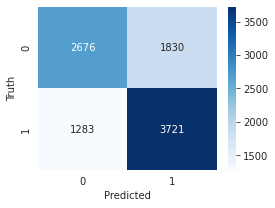

In [89]:
y_pred = knn.predict(X_valid)

conf_mat = confusion_matrix(y_true=y_valid, y_pred=y_pred)

plt.figure(figsize=(4,3))
sns.heatmap(conf_mat, cmap=plt.cm.Blues, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [90]:
parameters = {"n_neighbors": list(range(5, 80, 5)), 
              "weights": ["uniform", "distance"],
              "metric": ['euclidean', 'manhattan', 'minkowski'],
              "n_jobs": [-1]}


knn = KNeighborsClassifier()
grid_search_knn = GridSearchCV(knn, parameters, cv=3, n_jobs=2, scoring="roc_auc")

grid_search_knn.fit(X_train, y_train)

knn_best = grid_search_knn.best_estimator_

print(grid_search_knn.best_params_)
print(grid_search_knn.best_estimator_)

{'metric': 'manhattan', 'n_jobs': -1, 'n_neighbors': 75, 'weights': 'distance'}
KNeighborsClassifier(metric='manhattan', n_jobs=-1, n_neighbors=75,
                     weights='distance')


Text(15.0, 0.5, 'Truth')

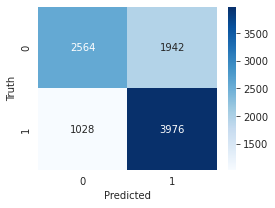

In [91]:
y_pred = knn_best.predict(X_valid)

conf_mat = confusion_matrix(y_true=y_valid, y_pred=y_pred)

plt.figure(figsize=(4,3))
sns.heatmap(conf_mat, cmap=plt.cm.Blues, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Truth')

## 5. Voting

In [84]:
rf = RandomForestClassifier(max_depth=14, min_samples_leaf=4,
                            n_estimators=400, n_jobs=-1, random_state=SEED)
etc = ExtraTreesClassifier(bootstrap='True', max_depth=18, min_samples_leaf=2,
                           n_estimators=500, n_jobs=-1, random_state=SEED)
knn = KNeighborsClassifier(metric='manhattan', n_jobs=-1, n_neighbors=75,
                           weights='distance')

svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)

base_models = [("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm),  ("XGB", xgb), 
               ("LR", lr)]

In [85]:
voting_soft = VotingClassifier(estimators=base_models, voting = 'soft')

voting_soft.fit(X_s_train, y_s_train)
scores = cross_val_score(voting_soft, X_s_train, y_s_train, cv=3, scoring="roc_auc")
print(f"\n\n{voting_soft.__class__.__name__}: {scores.mean()}")

y_pred = voting_soft.predict_proba(X_valid)[:, 1]

valid_score = roc_auc_score(y_valid, y_pred)
print("ROC-AUC score на отложенной части:", valid_score)

valid_accuracy = accuracy_score(y_valid, y_pred > 0.5)
print("Accuracy score (p > 0.5) на отложенной части:", valid_accuracy)

[18:03:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:03:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:04:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:05:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

Text(15.0, 0.5, 'Truth')

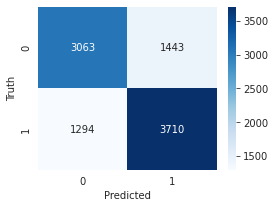

In [86]:
y_pred = voting_soft.predict(X_valid)

conf_mat = confusion_matrix(y_true=y_valid, y_pred=y_pred)

plt.figure(figsize=(4,3))
sns.heatmap(conf_mat, cmap=plt.cm.Blues, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Truth')

#### Много разных моделей

In [ ]:
rf.fit(X_s_train, y_s_train)
cat.fit(X_s_train, y_s_train)
etc.fit(X_s_train, y_s_train)
knn.fit(X_s_train, y_s_train)
svc_lin.fit(X_s_train, y_s_train)
svc_rbf.fit(X_s_train, y_s_train)
xgb.fit(X_s_train, y_s_train)
lgbm.fit(X_s_train, y_s_train)
lr.fit(X_s_train, y_s_train)

## END YOUR CODE HERE ##

for model in [rf, cat, etc, knn, svc_lin, svc_rbf, xgb, lgbm, lr]: 
    scores = cross_val_score(model, X_b_train, y_b_train, cv=3, scoring="roc_auc")
    print(f"{model.__class__.__name__}: {scores.mean()}")

[18:32:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
RandomForestClassifier: 0.8170343093096454
CatBoostClassifier: 0.8185513483417997
ExtraTreesClassifier: 0.8077153688716413
KNeighborsClassifier: 0.7858169820801454
SVC: 0.8055200255190709
SVC: 0.7973512099255009
[19:07:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:07:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:07:12] WARNING: ../src/learn

## PCA

In [92]:
from sklearn.decomposition import PCA, KernelPCA

In [273]:
k = X_train.shape[1]

pca = PCA(n_components=k, random_state=SEED)

pca.fit(X_train)

PCA(n_components=155, random_state=10801)

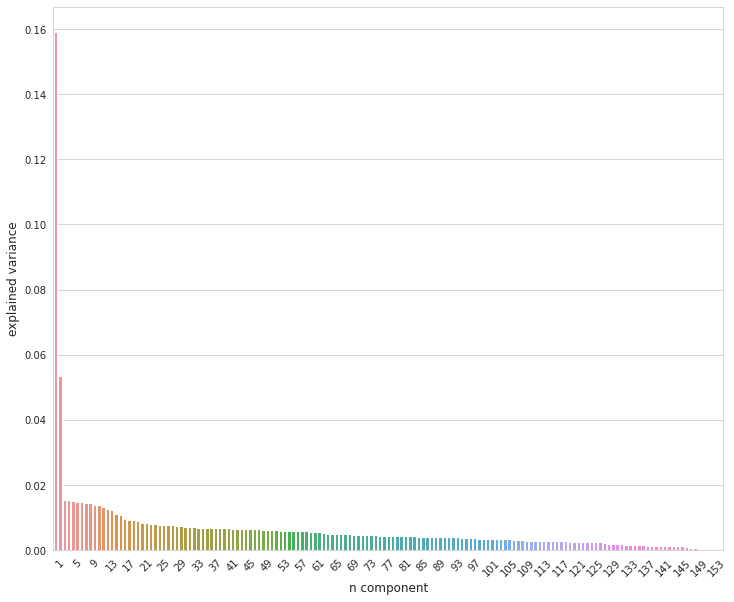

In [274]:
explained_variance_ratio_pca = pca.explained_variance_ratio_

plt.figure(figsize=(12, 10));
sns.barplot(list(range(1, k+1)), explained_variance_ratio_pca);
plt.ylabel('explained variance', fontsize=12);
plt.xlabel('n component', fontsize=12);
plt.xticks(ticks=list(range(1, k+1, 4)),
           labels=list(range(1, k+1, 4)),
           rotation=45);

In [275]:
#explained_variance_ratio_pca = pca.explained_variance_ratio_
chosen_number_pca = np.where(np.cumsum(explained_variance_ratio_pca) >= 0.95)[0][0]
chosen_number_pca

119

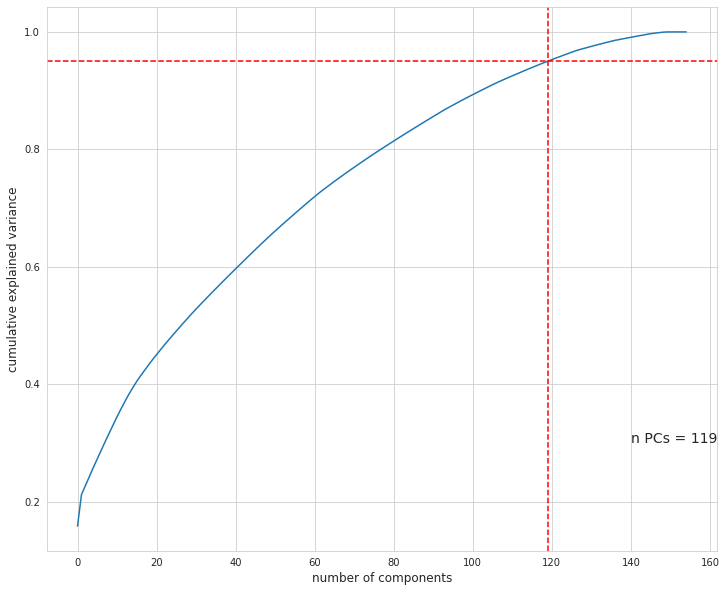

In [276]:
plt.figure(figsize=(12, 10));
plt.plot(np.cumsum(explained_variance_ratio_pca))
plt.xlabel('number of components', fontsize=12)
plt.ylabel('cumulative explained variance', fontsize=12);
plt.axhline(y=0.95, color='red', linestyle='--');
plt.axvline(x=chosen_number_pca, color='red', linestyle='--');
plt.text(140, 0.3, f"n PCs = {chosen_number_pca}", clip_on=True, fontsize=14);

In [277]:
pca = PCA(n_components=chosen_number_pca, random_state=SEED)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_valid)

In [286]:
# LR

lr = LogisticRegression(C=0.1, class_weight='balanced', max_iter=10000, penalty='l1',
                        random_state=10801, solver='liblinear')

lr.fit(X_train_pca, y_train)
scores = cross_val_score(lr, X_train_pca, y_train, cv=3, scoring="roc_auc")
print(f"{lr.__class__.__name__}: {scores.mean()}")

y_pred = lr.predict_proba(X_test_pca)[:, 1]

valid_score = roc_auc_score(y_valid, y_pred)
print("ROC-AUC score на отложенной части:", valid_score)

valid_accuracy = accuracy_score(y_valid, y_pred > 0.5)
print("Accuracy score (p > 0.5) на отложенной части:", valid_accuracy)


#LogisticRegression: 0.8069993048250255
#ROC-AUC score на отложенной части: 0.8058114094609797
#Accuracy score (p > 0.5) на отложенной части: 0.7192429022082019

LogisticRegression: 0.8075869546327615
ROC-AUC score на отложенной части: 0.8056106823373969
Accuracy score (p > 0.5) на отложенной части: 0.7153522607781283


In [287]:
# RF

cls_best = RandomForestClassifier(max_depth=16, min_samples_leaf=4,
                                  n_estimators=400, n_jobs=-1, random_state=SEED)

cls_best.fit(X_train_pca, y_train)

y_pred = cls_best.predict_proba(X_test_pca)[:, 1]

valid_score = roc_auc_score(y_valid, y_pred)
print("ROC-AUC score на отложенной части:", valid_score)

valid_accuracy = accuracy_score(y_valid, y_pred > 0.5)
print("Accuracy score (p > 0.5) на отложенной части:", valid_accuracy)


# ROC-AUC score на отложенной части: 0.7935548587317451
# Accuracy score (p > 0.5) на отложенной части: 0.7093585699263932

ROC-AUC score на отложенной части: 0.7970930401706154
Accuracy score (p > 0.5) на отложенной части: 0.7117770767613039


Text(15.0, 0.5, 'Truth')

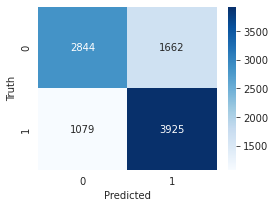

In [289]:
conf_mat = confusion_matrix(y_true=y_valid, y_pred= y_pred > 0.5)

plt.figure(figsize=(4,3))
sns.heatmap(conf_mat, cmap=plt.cm.Blues, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Truth')

# Подготовим посылку

In [61]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(df_test)

In [180]:
# RF Score: 0.82842
rf_model = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
rf_model.fit(train, y)

y_test_pred = rf_model.predict_proba(df_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_test.index)

submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))

df_submission.to_csv(''.join(['../data/', submission_filename]))

print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2022-03-31_15-37-08.csv


In [181]:
# Grid RF
# Score: 0.83139
rf_model = RandomForestClassifier(max_depth=14, min_samples_leaf=4,
                                  n_estimators=400, n_jobs=-1, random_state=SEED)
rf_model.fit(train, y)

y_test_pred = rf_model.predict_proba(df_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_test.index)

submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))

df_submission.to_csv(''.join(['../data/', submission_filename]))

print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2022-03-31_15-37-28.csv


In [199]:
# ETC
# Score: 0.81940

etc = ExtraTreesClassifier(bootstrap='True', max_depth=18, min_samples_leaf=2,
                           n_estimators=500, n_jobs=-1, random_state=SEED)

etc.fit(train, y)

y_test_pred = etc.predict_proba(df_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_test.index)

submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))

df_submission.to_csv(''.join(['../data/', submission_filename]))

print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2022-03-31_17-17-20.csv


In [200]:
# voting
# Score: 0.82974

rf = RandomForestClassifier(max_depth=14, 
                            min_samples_leaf=4,
                            n_estimators=400, 
                            n_jobs=-1, 
                            random_state=SEED)

lr = LogisticRegression(C=0.1, 
                        class_weight='balanced', 
                        max_iter=1000, 
                        penalty='l1',
                        solver='liblinear', 
                        random_state=SEED)

base_models = [("RF", rf), 
               ("LR", lr)]

voting_soft = VotingClassifier(estimators=base_models, voting = 'soft')
voting_soft.fit(train_scaled, y)

y_test_pred = voting_soft.predict_proba(test_scaled)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_test.index)

submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))

df_submission.to_csv(''.join(['../data/', submission_filename]))

print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2022-03-31_17-18-15.csv


In [ ]:
# voting 2
# Score: 0.82888

rf = RandomForestClassifier(max_depth=14, 
                            min_samples_leaf=4,
                            n_estimators=400, 
                            n_jobs=-1, 
                            random_state=SEED)

lr = LogisticRegression(C=0.1, 
                        class_weight='balanced', 
                        max_iter=1000, 
                        penalty='l1',
                        solver='liblinear', 
                        random_state=SEED)

etc = ExtraTreesClassifier(bootstrap='True', max_depth=18, min_samples_leaf=2,
                     n_estimators=500, n_jobs=-1, random_state=SEED)

base_models = [("RF", rf), 
               ("LR", lr),
               ('ETC', etc)]

voting_soft = VotingClassifier(estimators=base_models, voting = 'soft')
voting_soft.fit(train_scaled, y)

y_test_pred = voting_soft.predict_proba(test_scaled)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_test.index)

submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))

df_submission.to_csv(''.join(['../data/', submission_filename]))

print("Файл посылки сохранен, как: {}".format(submission_filename))


In [93]:
# 0.83332 Best 40th

rf = RandomForestClassifier(max_depth=14, min_samples_leaf=4,
                            n_estimators=400, n_jobs=-1, random_state=SEED)
etc = ExtraTreesClassifier(bootstrap='True', max_depth=18, min_samples_leaf=2,
                           n_estimators=500, n_jobs=-1, random_state=SEED)
knn = KNeighborsClassifier(metric='manhattan', n_jobs=-1, n_neighbors=75,
                           weights='distance')
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
lr = LogisticRegression(C=0.1, 
                        class_weight='balanced', 
                        max_iter=1000, 
                        penalty='l1',
                        solver='liblinear', 
                        random_state=SEED)


base_models = [("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm),  ("XGB", xgb), 
               ("LR", lr)]

voting_soft = VotingClassifier(estimators=base_models, voting = 'soft')
voting_soft.fit(train_scaled, y)

y_test_pred = voting_soft.predict_proba(test_scaled)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_test.index)

submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))

df_submission.to_csv(''.join(['../data/', submission_filename]))

print("Файл посылки сохранен, как: {}".format(submission_filename))

[04:01:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Файл посылки сохранен, как: submission_2022-04-02_04-03-19.csv


## PCA

In [145]:
k = train_scaled.shape[1]
pca_fin = PCA(n_components=k, random_state=SEED)
pca_fin.fit(train_scaled)

PCA(n_components=155, random_state=10801)

In [146]:
explained_variance_ratio_pca_fin = pca_fin.explained_variance_ratio_
chosen_number_pca_fin = np.where(np.cumsum(explained_variance_ratio_pca_fin) >= 0.95)[0][0]
chosen_number_pca_fin

120

In [147]:
pca_fin = PCA(n_components=chosen_number_pca_fin, random_state=SEED)
X_train_pca = pca.fit_transform(train_scaled)
X_test_pca = pca.transform(test_scaled)

In [297]:
# RF + pca 
# Score: 0.83139 pred 
# now Score: 0.81033 :C 

rf_model = RandomForestClassifier(max_depth=14, min_samples_leaf=4,
                                  n_estimators=400, n_jobs=-1, random_state=SEED)
rf_model.fit(X_train_pca, y)

y_test_pred = rf_model.predict_proba(X_test_pca)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_test.index)

submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))

df_submission.to_csv(''.join(['../data/', submission_filename]))

print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2022-04-02_14-33-51.csv


In [298]:
# voting 2  + pca 
# prew_score Score: 0.82888
# now Score: 0.81898 :C

rf = RandomForestClassifier(max_depth=14, 
                            min_samples_leaf=4,
                            n_estimators=400, 
                            n_jobs=-1, 
                            random_state=SEED)

lr = LogisticRegression(C=0.1, 
                        class_weight='balanced', 
                        max_iter=1000, 
                        penalty='l1',
                        solver='liblinear', 
                        random_state=SEED)

etc = ExtraTreesClassifier(bootstrap='True', max_depth=18, min_samples_leaf=2,
                     n_estimators=500, n_jobs=-1, random_state=SEED)

base_models = [("RF", rf), 
               ("LR", lr),
               ('ETC', etc)]

voting_soft = VotingClassifier(estimators=base_models, voting = 'soft')
voting_soft.fit(X_train_pca, y)

y_test_pred = voting_soft.predict_proba(X_test_pca)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_test.index)

submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))

df_submission.to_csv(''.join(['../data/', submission_filename]))

print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2022-04-02_14-36-38.csv


## Torch посылка
Score: 0.75844
максимально безуспешная

In [86]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [117]:
X_train_pca.shape

(22188, 149)

In [148]:
class TrainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

    
class TestData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)


    
class BinaryClassification(nn.Module):
    def __init__(self):
        super(BinaryClassification, self).__init__()
        # Number of input features is 149.
        self.layer_1 = nn.Linear(149, 1000) 
        self.layer_2 = nn.Linear(1000, 500)
        self.layer_out = nn.Linear(500, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(1000)
        self.batchnorm2 = nn.BatchNorm1d(500)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x
    
    
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [149]:
train_data = TrainData(torch.FloatTensor(X_train_pca), 
                       torch.FloatTensor(y))

test_data = TestData(torch.FloatTensor(X_test_pca))

In [150]:
EPOCHS = 80
BATCH_SIZE = 1000
LEARNING_RATE = 0.001

In [151]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [152]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [153]:
model = BinaryClassification()
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

model.train()

for e in range(1, EPOCHS + 1):
    epoch_loss = 0
    epoch_acc = 0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

BinaryClassification(
  (layer_1): Linear(in_features=149, out_features=1000, bias=True)
  (layer_2): Linear(in_features=1000, out_features=500, bias=True)
  (layer_out): Linear(in_features=500, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Epoch 001: | Loss: 0.56847 | Acc: 70.125
Epoch 002: | Loss: 0.49654 | Acc: 74.094
Epoch 003: | Loss: 0.47185 | Acc: 75.812
Epoch 004: | Loss: 0.43997 | Acc: 78.031
Epoch 005: | Loss: 0.40247 | Acc: 80.531
Epoch 006: | Loss: 0.35765 | Acc: 83.312
Epoch 007: | Loss: 0.30132 | Acc: 86.406
Epoch 008: | Loss: 0.25999 | Acc: 88.812
Epoch 009: | Loss: 0.20960 | Acc: 91.469
Epoch 010: | Loss: 0.17308 | Acc: 93.094
Epoch 011: | Loss: 0.13203 | Acc: 95.188
Epoch 012: | Loss: 0.10735 | Acc: 96.219
Epoch 013: | Loss: 0.07973 | 

In [154]:
y_pred_list = []
model.eval()

with torch.no_grad():
    
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        #y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_test_pred.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [155]:
df_submission = pd.DataFrame({"radiant_win_prob": y_pred_list}, 
                                 index=df_test.index)

submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))

df_submission.to_csv(''.join(['../data/', submission_filename]))

print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2022-04-02_15-26-12.csv


# Соберем данные по-другому
Добавим и уберем данные иначе

In [62]:
df_train_features_extended.to_csv('../data/df_train_features_extended.csv')  
test.to_csv('../data/test.csv')  
train.to_csv('../data/train.csv')  
df_test.to_csv('../data/df_test.csv') 

In [63]:
df_train_features_extended = pd.read_csv('../data/df_train_features_extended.csv', index_col=0)
test = pd.read_csv('../data/test.csv', index_col=0)
train = pd.read_csv('../data/train.csv', index_col=0)
df_test = pd.read_csv('../data/df_test.csv', index_col=0)

In [64]:
all_train = train.copy()
all_test = df_test.copy()

In [65]:
def add_new_features(df_features, matches_file, total_matches=31698):
    """
    Аргуенты
    -------
    df_features: таблица с данными
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Добавляет новые признаки в таблицу
    """
    
    for match in read_matches(matches_file, total_matches=total_matches):
        match_id_hash = match['match_id_hash']
        
        dire_observers_placed, rad_observers_placed = 0, 0
        dire_purchase_log, rad_purchase_log = 0, 0
        dire_inventory, rad_inventory = 0, 0

        for player in match["players"]:
            if player['player_slot'] > 90:
                dire_observers_placed += player["observers_placed"]
                dire_purchase_log += len(player["purchase_log"])
                dire_inventory += len(player["hero_inventory"])

            else:
                rad_observers_placed += player["observers_placed"]
                rad_purchase_log += len(player["purchase_log"])
                rad_inventory += len(player["hero_inventory"])
            
            
        df_features.loc[match_id_hash, "dire_purchases"] = dire_purchase_log
        df_features.loc[match_id_hash, "rad_purchases"] = rad_purchase_log 
        
        df_features.loc[match_id_hash, "dire_inventory"] = dire_inventory
        df_features.loc[match_id_hash, "rad_inventory"] = rad_inventory 
        
        for team_fight in match["teamfights"]:
            for i, team_player in enumerate(team_fight['players']):
                if i < 5:
                    df_features.loc[match_id_hash, f"r{i+1}_damage"] = team_player.get("damage", 0)
                    df_features.loc[match_id_hash, f"r{i+1}_healing"] = team_player.get("healing", 0)
                    
                else:
                    df_features.loc[match_id_hash, f"d{i-4}_damage"] = team_player.get("damage", 0)      
                    df_features.loc[match_id_hash, f"d{i-4}_healing"] = team_player.get("healing", 0)  

In [66]:
# Добавим новые
add_new_features(all_test, 
                 os.path.join('../data', 
                              "test_raw_data.jsonl"),
                 total_matches = 7977)

  0%|          | 0/7977 [00:00<?, ?it/s]

In [67]:
add_new_features(all_train, 
                 os.path.join('../data', 
                              "train_raw_data.jsonl"),
                 total_matches = 31698)

  0%|          | 0/31698 [00:00<?, ?it/s]

In [68]:
all_train['d_teamfight_participation'] = (all_train['d1_teamfight_participation'] + 
                                          all_train['d2_teamfight_participation'] + 
                                          all_train['d3_teamfight_participation'] + 
                                          all_train['d4_teamfight_participation'] +
                                          all_train['d5_teamfight_participation'])

all_test['d_teamfight_participation'] = (all_test['d1_teamfight_participation'] + 
                                          all_test['d2_teamfight_participation'] + 
                                          all_test['d3_teamfight_participation'] + 
                                          all_test['d4_teamfight_participation'] +
                                          all_test['d5_teamfight_participation'])

all_train['r_teamfight_participation'] = (all_train['r1_teamfight_participation'] + 
                                          all_train['r2_teamfight_participation'] + 
                                          all_train['r3_teamfight_participation'] + 
                                          all_train['r4_teamfight_participation'] +
                                          all_train['r5_teamfight_participation'])

all_test['r_teamfight_participation'] = (all_test['r1_teamfight_participation'] + 
                                          all_test['r2_teamfight_participation'] + 
                                          all_test['r3_teamfight_participation'] + 
                                          all_test['r4_teamfight_participation'] +
                                          all_test['r5_teamfight_participation'])


all_train = all_train.drop(['d1_teamfight_participation', 'd2_teamfight_participation',
                            'd3_teamfight_participation', 'd4_teamfight_participation', 
                            'd5_teamfight_participation',
                            'r1_teamfight_participation', 'r2_teamfight_participation',
                            'r3_teamfight_participation', 'r4_teamfight_participation', 
                            'r5_teamfight_participation'], axis=1)

all_test = all_test.drop(['d1_teamfight_participation', 'd2_teamfight_participation',
                            'd3_teamfight_participation', 'd4_teamfight_participation', 
                            'd5_teamfight_participation',
                            'r1_teamfight_participation', 'r2_teamfight_participation',
                            'r3_teamfight_participation', 'r4_teamfight_participation', 
                            'r5_teamfight_participation'], axis=1)

In [69]:
all_train['d_stuns'] = (all_train['d1_stuns'] + all_train['d2_stuns'] + 
                        all_train['d3_stuns'] + all_train['d4_stuns'] +
                        all_train['d5_stuns'])

all_train['r_stuns'] = (all_train['r1_stuns'] + all_train['r2_stuns'] + 
                       all_train['r3_stuns'] + all_train['r4_stuns'] +
                       all_train['r5_stuns'])


all_test['d_stuns'] = (all_test['d1_stuns'] + all_test['d2_stuns'] + 
                       all_test['d3_stuns'] + all_test['d4_stuns'] +
                       all_test['d5_stuns'])

all_test['r_stuns'] = (all_test['r1_stuns'] + all_test['r2_stuns'] + 
                       all_test['r3_stuns'] + all_test['r4_stuns'] +
                       all_test['r5_stuns'])

all_train = all_train.drop(['d1_stuns', 'd2_stuns',
                            'd3_stuns', 'd4_stuns', 
                            'd5_stuns',
                            'r1_stuns', 'r2_stuns',
                            'r3_stuns', 'r4_stuns', 
                            'r5_stuns'], axis=1)

all_test = all_test.drop(['d1_stuns', 'd2_stuns',
                            'd3_stuns', 'd4_stuns', 
                            'd5_stuns',
                            'r1_stuns', 'r2_stuns',
                            'r3_stuns', 'r4_stuns', 
                            'r5_stuns'], axis=1)

In [70]:
all_train['diff_stuns'] = np.where(all_train['d_stuns'] > 0,
                                   all_train['r_stuns']  / all_train['d_stuns'],
                                   all_train['r_stuns'])

all_test['diff_stuns'] = np.where(all_test['d_stuns'] > 0,
                                   all_test['r_stuns']  / all_test['d_stuns'],
                                   all_test['r_stuns'])

all_test = all_test.drop(['d_stuns', 'r_stuns'], axis=1)

all_train = all_train.drop(['d_stuns', 'r_stuns'], axis=1)

In [71]:
all_train['r_towers_killed'] = 0
all_train['d_towers_killed'] = 0
all_test['r_towers_killed'] = 0
all_test['d_towers_killed'] = 0

for i in range(1, 6):
    all_train['r_towers_killed'] += all_train[f'r{i}_towers_killed']
    all_train['d_towers_killed'] += all_train[f'd{i}_towers_killed']
    all_test['r_towers_killed'] += all_test[f'r{i}_towers_killed']
    all_test['d_towers_killed'] += all_test[f'd{i}_towers_killed']
    
    all_train = all_train.drop([f'r{i}_towers_killed', f'd{i}_towers_killed'], axis=1)
    all_test = all_test.drop([f'r{i}_towers_killed', f'd{i}_towers_killed'], axis=1)

In [72]:
all_train = all_train.drop(['radiant_tower_kills', 'dire_tower_kills'], axis=1)
all_test = all_test.drop(['radiant_tower_kills', 'dire_tower_kills'], axis=1)

# LogisticRegression: 0.8086897426244718

In [73]:
all_train.fillna(0, inplace=True)
all_test.fillna(0, inplace=True)

In [74]:
all_train['diff_purchases'] = np.where(all_train['dire_purchases'] > 0,
                                   all_train['rad_purchases']  / all_train['dire_purchases'],
                                   all_train['rad_purchases'])

all_test['diff_purchases'] = np.where(all_test['dire_purchases'] > 0,
                                   all_test['rad_purchases']  / all_test['dire_purchases'],
                                   all_test['rad_purchases'])

all_train = all_train.drop(['rad_purchases', 'dire_purchases'], axis=1)
all_test = all_test.drop(['rad_purchases', 'dire_purchases'], axis=1)

# LogisticRegression: 0.809310943152597

In [75]:
all_train['d_rune_pickups'] = 0
all_train['r_rune_pickups'] = 0

all_test['d_rune_pickups'] = 0
all_test['r_rune_pickups'] = 0

for i in range(1, 6):
    all_train['r_rune_pickups'] += all_train[f'r{i}_rune_pickups'] 
    all_train['d_rune_pickups'] += all_train[f'd{i}_rune_pickups'] 
    
    all_train = all_train.drop([f'r{i}_rune_pickups', f'd{i}_rune_pickups',], axis=1)
    
    all_test['r_rune_pickups'] += all_test[f'r{i}_rune_pickups'] 
    all_test['d_rune_pickups'] += all_test[f'd{i}_rune_pickups'] 
    
    all_test = all_test.drop([f'r{i}_rune_pickups', f'd{i}_rune_pickups',], axis=1)
    
# LogisticRegression: 0.8094234154694778

In [76]:
all_train['d_obs_placed'] = 0
all_train['r_obs_placed'] = 0

all_test['d_obs_placed'] = 0
all_test['r_obs_placed'] = 0

for i in range(1, 6):
    all_train['r_obs_placed'] += all_train[f'r{i}_obs_placed'] 
    all_train['d_obs_placed'] += all_train[f'd{i}_obs_placed'] 
    
    all_train = all_train.drop([f'r{i}_obs_placed', f'd{i}_obs_placed',], axis=1)
    
    all_test['r_obs_placed'] += all_test[f'r{i}_obs_placed'] 
    all_test['d_obs_placed'] += all_test[f'd{i}_obs_placed'] 
    
    all_test = all_test.drop([f'r{i}_obs_placed', f'd{i}_obs_placed',], axis=1)
    
# LogisticRegression: 0.8095396595923311

In [77]:
all_train['d_healing'] = 0
all_train['r_healing'] = 0

all_test['d_healing'] = 0
all_test['r_healing'] = 0

for i in range(1, 6):
    all_train['r_healing'] += all_train[f'r{i}_healing'] 
    all_train['d_healing'] += all_train[f'd{i}_healing'] 
    
    all_train = all_train.drop([f'r{i}_healing', f'd{i}_healing',], axis=1)
    
    all_test['r_healing'] += all_test[f'r{i}_healing'] 
    all_test['d_healing'] += all_test[f'd{i}_healing'] 
    
    all_test = all_test.drop([f'r{i}_healing', f'd{i}_healing',], axis=1)

# LogisticRegression: 0.8096637247316633

In [78]:
# заменим разницу на деление


all_train['ratio_towers_kills'] = np.where(all_train['d_towers_killed'] > 0,
                                   all_train['r_towers_killed']  / all_train['d_towers_killed'],
                                   all_train['r_towers_killed'])

all_test['ratio_towers_kills'] = np.where(all_test['d_towers_killed'] > 0,
                                   all_test['r_towers_killed']  / all_test['d_towers_killed'],
                                   all_test['r_towers_killed'])

all_test = all_test.drop(['d_towers_killed', 'r_towers_killed'], axis=1)

all_train = all_train.drop(['d_towers_killed', 'r_towers_killed'], axis=1)

# LogisticRegression: 0.8095865785748678

In [79]:
# заменим разницу на деление


all_train['aegis_stolen_diff'] = np.where(all_train['aegis_stolen_dire'] > 0,
                                   all_train['aegis_stolen_radiant']  / all_train['aegis_stolen_dire'],
                                   all_train['aegis_stolen_radiant'])

all_test['aegis_stolen_diff'] = np.where(all_test['aegis_stolen_dire'] > 0,
                                   all_test['aegis_stolen_radiant']  / all_test['aegis_stolen_dire'],
                                   all_test['aegis_stolen_radiant'])

all_test = all_test.drop(['aegis_stolen_dire', 'aegis_stolen_radiant'], axis=1)

all_train = all_train.drop(['aegis_stolen_dire', 'aegis_stolen_radiant'], axis=1)

# LogisticRegression: 0.8096952077946127

In [80]:
all_train['d_denies'] = 0
all_train['r_denies'] = 0

all_test['d_denies'] = 0
all_test['r_denies'] = 0

for i in range(1, 6):
    all_train['r_denies'] += all_train[f'r{i}_denies'] 
    all_train['d_denies'] += all_train[f'd{i}_denies'] 
    
    all_train = all_train.drop([f'r{i}_denies', f'd{i}_denies',], axis=1)
    
    all_test['r_denies'] += all_test[f'r{i}_denies'] 
    all_test['d_denies'] += all_test[f'd{i}_denies'] 
    
    all_test = all_test.drop([f'r{i}_denies', f'd{i}_denies',], axis=1)
    
# LogisticRegression: 0.809722773893356

In [81]:
all_test = all_test.drop(['aegis_denied_radiant'], axis=1)
all_train = all_train.drop(['aegis_denied_radiant'], axis=1)
# LogisticRegression: 0.8097426049093235

#### Save and read data

In [82]:
all_train.to_csv('../data/all_train.csv')  
all_test.to_csv('../data/all_test.csv')  

In [83]:
df_train_targets = pd.read_csv("../data/train_targets.csv", index_col="match_id_hash")
y = df_train_targets["radiant_win"].values.astype("int8")

all_train = pd.read_csv('../data/all_train.csv', index_col=0)
all_test = pd.read_csv('../data/all_test.csv', index_col=0)

In [84]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(all_train)
test_scaled = scaler.transform(all_test)

In [85]:
X_train, X_valid, y_train, y_valid = train_test_split(all_train, y, 
                                                      test_size=0.35, 
                                                      random_state=SEED)

X_S_train, X_S_valid, y_S_train, y_S_valid = train_test_split(X_valid, y_valid, 
                                                              test_size=0.3, 
                                                              random_state=SEED)

X_S_train = scaler.transform(X_S_train)
X_S_valid = scaler.transform(X_S_valid)

#### Важные признаки

In [93]:
lr = LogisticRegression(C=0.1, 
                        class_weight='balanced', 
                        max_iter=1000, 
                        penalty='l1',
                        solver='liblinear', 
                        random_state=SEED,
                        n_jobs=2)

lr.fit(train_scaled, y)

coefficients = np.hstack((lr.intercept_, lr.coef_[0]))
coefficients_df = pd.DataFrame(data={'variable': ['intercept'] + list(all_test.columns), 'coefficient': coefficients})
coefficients_df = coefficients_df.sort_values(by='coefficient', ascending=False, key=lambda col: col.abs())

In [94]:
coefficients_df.iloc[:15,:]

,variable,coefficient
55,diff_tower_kills,0.495138
76,rat_lh,0.357171
73,r4_KDA,0.155116
106,diff_purchases,0.147884
70,d3_KDA,-0.137957
108,r_rune_pickups,-0.132489
75,r5_KDA,0.124729
72,d4_KDA,-0.121081
68,d2_KDA,-0.113316
67,r1_KDA,0.111681


In [95]:
coefficients_df.iloc[100:,:]

,variable,coefficient
78,diff_xp,0.013996
83,r3h_win_rate,0.013475
31,d1_max_health,0.011301
62,aegis_denied_diff,0.010687
37,d2_x,0.010627
105,diff_stuns,0.007463
79,r1h_win_rate,0.006455
2,game_mode,0.005859
63,aegis_denied_dire,-0.004462
58,diff_roshan_kills,0.003513


In [96]:
scores = cross_val_score(lr, train_scaled, y, cv=3, scoring="roc_auc")
print(f"{lr.__class__.__name__}: {scores.mean()}")
# LogisticRegression: 0.809310943152597
# LogisticRegression: 0.8094234154694778
# LogisticRegression: 0.8095396595923311
# LogisticRegression: 0.8095865785748678
# LogisticRegression: 0.8096637247316633
# LogisticRegression: 0.8096952077946127
# LogisticRegression: 0.809681340471546
# LogisticRegression: 0.8097079246559832
# LogisticRegression: 0.809722773893356
# LogisticRegression: 0.8097233007968411
# LogisticRegression: 0.8097423414300478
# LogisticRegression: 0.809722773893356

LogisticRegression: 0.8097426049093235


In [90]:
rf = RandomForestClassifier(max_depth=14, 
                            min_samples_leaf=4,
                            n_estimators=400, 
                            n_jobs=2, 
                            random_state=SEED)

rf.fit(train_scaled, y)

scores = cross_val_score(rf, train_scaled, y, cv=3, scoring="roc_auc")
print(f"{rf.__class__.__name__}: {scores.mean()}")

# RandomForestClassifier: 0.8173997004850712
# RandomForestClassifier: 0.8171855606628773
# RandomForestClassifier: 0.81786265099703
# RandomForestClassifier: 0.8179203274303832
# RandomForestClassifier: 0.8172504861602654
# RandomForestClassifier: 0.8177333532736082
# RandomForestClassifier: 0.817881845727586
# 

RandomForestClassifier: 0.817881845727586


In [17]:
rf = RandomForestClassifier(max_depth=14, min_samples_leaf=4,
                            n_estimators=400, n_jobs=-1, random_state=SEED)
knn = KNeighborsClassifier(metric='manhattan', n_jobs=-1, n_neighbors=75,
                           weights='distance')
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
lr = LogisticRegression(C=0.1, 
                        class_weight='balanced', 
                        max_iter=1000, 
                        penalty='l1',
                        solver='liblinear', 
                        random_state=SEED)


base_models = [("RF", rf), 
               ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm),  ("XGB", xgb), 
               ("LR", lr)]

voting_soft = VotingClassifier(estimators=base_models, voting = 'soft')
voting_soft.fit(X_S_train, y_S_train)

scores = cross_val_score(voting_soft, X_S_train, y_S_train, cv=3, scoring="roc_auc")
print(f"{voting_soft.__class__.__name__}: {scores.mean()}")

y_pred = voting_soft.predict_proba(X_S_valid)[:, 1]

valid_score = roc_auc_score(y_S_valid, y_pred)
print("ROC-AUC score на отложенной части:", valid_score)

valid_accuracy = accuracy_score(y_S_valid, y_pred > 0.5)
print("Accuracy score (p > 0.5) на отложенной части:", valid_accuracy)


[00:30:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:30:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:31:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:32:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [86]:
from itertools import combinations
from scipy.stats import pearsonr

In [19]:
def base_model_pair_correlation_for_voting_clf(ensemble, X):
    corrs = []
    base_model_names = [f"{est.__class__.__name__}" for est in ensemble.estimators_]

    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        if not isinstance(est1, SVC):
            ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t1 = est1.decision_function(Xi_test)


        if not isinstance(est2, SVC):
            ypred_t2 = est2.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t2 = est2.decision_function(Xi_test)
        corrs.append((est1, est2, pearsonr(ypred_t1, ypred_t2)[0]))


    return corrs

In [20]:
correlations = base_model_pair_correlation_for_voting_clf(voting_soft, X_S_train)

sorted(correlations, key=lambda x: x[-1], reverse=True)

[(KNeighborsClassifier(metric='manhattan', n_jobs=-1, n_neighbors=75,
                       weights='distance'),
  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
                gamma=0, gpu_id=-1, importance_type=None,
                interaction_constraints='', learning_rate=0.300000012,
                max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
                monotone_constraints='()', n_estimators=100, n_jobs=8,
                num_parallel_tree=1, predictor='auto', random_state=10801,
                reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
                tree_method='exact', validate_parameters=1, verbosity=None),
  0.9808220222561609),
 (<catboost.core.CatBoostClassifier at 0x7f0d9f2211e0>,
  LGBMClassifier(random_state=10801),
  0.9763447847750275),
 (RandomForestClassifier(max_depth=14, min_samples_leaf=4, n_estimators=400,
        

In [37]:
'''
base_models = [("RF", rf), 
               ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm),  ("XGB", xgb), 
               ("LR", lr)]
'''

def rf():
    return RandomForestClassifier(max_depth=14, min_samples_leaf=4,
                            n_estimators=400, n_jobs=-1, random_state=SEED)

def knn():
    return KNeighborsClassifier(metric='manhattan', n_jobs=-1, n_neighbors=75,
                           weights='distance')

def svc_lin():
    return SVC(kernel='linear', probability=True, random_state=SEED)

def svc_rbf():
    return SVC(kernel='rbf', probability=True, random_state=SEED)

def cat():
    return catboost.CatBoostClassifier(verbose=0, random_seed=SEED)

def lgbm():
    return lightgbm.LGBMClassifier(random_state=SEED)

def lgbm_rf():
    return lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)

def xgb():
    return xgboost.XGBClassifier(random_state=SEED)

def xgb_rf():
    return xgboost.XGBRFClassifier(random_state=SEED)

def lr():
    return LogisticRegression(C=0.1, 
                        class_weight='balanced', 
                        max_iter=1000, 
                        penalty='l1',
                        solver='liblinear', 
                        random_state=SEED)


base_models = [("RF", rf), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr)]

In [38]:
subsets = []

for L in range(1, len(base_models)+1):
    for subset in combinations(base_models, L):
        subsets.append(subset)

In [39]:
import logging

logging.basicConfig(level=logging.ERROR)

In [40]:
import time

results = []

for i, subset in enumerate(subsets):

    subset = [(name, f()) for name, f in subset]
    voting_soft = VotingClassifier(estimators=subset, voting = 'soft')
    
    voting_soft.fit(X_S_train, y_S_train)
    
    scores = cross_val_score(voting_soft, X_S_train, y_S_train, cv=3, scoring="roc_auc")
    
    results.append([subset, scores.mean()])
    print(f'{time.time()}: {i}/{len(subsets)} classifiers: {len(subset)}')

1648939399.1083293: 0/1023 classifiers: 1
1648939401.6231213: 1/1023 classifiers: 1
1648939564.5351148: 2/1023 classifiers: 1
1648939613.826661: 3/1023 classifiers: 1
1648939646.1888945: 4/1023 classifiers: 1
1648939647.956273: 5/1023 classifiers: 1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
1648939649.9568045: 6/1023 classifiers: 1
[00:47:30] WARNING: ../src/learne

[00:57:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:57:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:57:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1648940268.374025: 25/1023 classifiers: 2
1648940270.6438398: 26/1023 classifiers: 2
1648940476.353901: 27/1023 classifiers: 2
1648940656.478983: 28/1023 classifiers: 2
1648940809.1157298: 29/1023 classifiers: 2
[LightGBM] [Warning] bagging_fra

[01:24:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1648941871.0517626: 42/1023 classifiers: 2
[01:24:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:24:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:25:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval

[01:26:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:26:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:26:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:26:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

1648943246.523884: 67/1023 classifiers: 3
[01:48:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:49:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:49:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:50:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_

[02:03:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:04:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:04:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1648944248.2715538: 83/1023 classifiers: 3
1648944260.9155395: 84/1023 classifiers: 3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=

[02:06:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:06:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:06:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1648944371.919566: 90/1023 classifiers: 3
1648944575.766305: 91/1023 classifiers: 3
1648944757.488095: 92/1023 classifiers: 3
1648944910.0654516: 93/1023 classifiers: 3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ign

[02:33:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1648945986.8807957: 106/1023 classifiers: 3
[02:33:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:33:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:33:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eva

[02:35:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:35:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:35:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:35:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[03:07:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:08:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:08:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1648948130.2287064: 128/1023 classifiers: 3
1648948311.505295: 129/1023 classifiers: 3
1648948465.3382742: 130/1023 classifiers: 3
[03:15:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with th

[03:32:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:32:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:32:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:32:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

1648950492.0877934: 148/1023 classifiers: 3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[03:48:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:48:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[0

1648950817.504249: 154/1023 classifiers: 3
1648950854.0969703: 155/1023 classifiers: 3
[03:54:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:54:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:54:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:54:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed fr

[03:59:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:59:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:59:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:59:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[04:01:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:01:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:01:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:01:45] WARNING:

1648951562.331051: 175/1023 classifiers: 4
1648951752.797022: 176/1023 classifiers: 4
1648951914.4341457: 177/1023 classifiers: 4
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
1648952075.632483: 178/1023 classifiers: 4
[04:15:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was chang

[04:32:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:32:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1648953163.2004564: 191/1023 classifiers: 4
1648953210.498232: 192/1023 classifiers: 4
1648953226.4280276: 193/1023 classifiers: 4
[04:33:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:33:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with th

[04:35:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:36:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:36:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1648953365.5879781: 200/1023 classifiers: 4
[04:36:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eva

[05:11:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1648955479.1806383: 212/1023 classifiers: 4
1648955669.354752: 213/1023 classifiers: 4
1648955830.4283895: 214/1023 classifiers: 4
[05:18:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[05:18:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[05:19:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with th

[05:36:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[05:36:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1648956974.4603374: 221/1023 classifiers: 4
[05:37:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[05:37:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eva

[05:54:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[05:54:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[05:54:36] WARNING: ../src/learner.cc:1115: St

[06:01:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[06:01:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1648958496.513375: 240/1023 classifiers: 4
[06:01:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[06:02:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval

[06:07:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[06:07:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1648958864.5992393: 247/1023 classifiers: 4
[06:07:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[06:08:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eva

[06:10:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[06:10:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[06:10:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[06:10:57] WARNING:

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
1648959772.4649217: 261/1023 classifiers: 4
[06:24:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[06:25:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[06:25:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to r

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[07:00:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[07:01:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1648962087.5919998: 274/1023 classifiers: 4
[L

1648963037.7427177: 281/1023 classifiers: 4
[07:17:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:18:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:18:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:18:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eva

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
1648963682.493451: 291/1023 classifiers: 4
[07:28:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:28:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:28:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to re

1648964065.1850266: 299/1023 classifiers: 4
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[07:34:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:34:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[0

[07:38:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:38:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1648964311.4325871: 306/1023 classifiers: 4
1648964317.5063336: 307/1023 classifiers: 4
[07:38:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:38:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed f

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[07:39:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[07:39:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1648964386.965995: 312/1023 classifiers: 4
[Li

[08:05:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:06:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1648965972.6905894: 321/1023 classifiers: 4
[08:07:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:08:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eva

[08:29:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:29:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1648967390.1322: 328/1023 classifiers: 4
[08:31:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:32:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_m

[08:56:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:56:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:56:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:57:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[09:16:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:16:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:17:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1648970238.3648698: 344/1023 classifiers: 4
[09:18:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eva

[09:29:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:29:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:29:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:29:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[09:41:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:41:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:41:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:41:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[09:49:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:49:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:49:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1648972187.453306: 364/1023 classifiers: 4
[09:50:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval

[09:54:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:54:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:54:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:54:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[09:59:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:59:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:59:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:59:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[10:02:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:02:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:02:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:02:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[10:03:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1648973017.9781342: 384/1023 classifiers: 4
1648973261.910874: 385/1023 classifiers: 5
1648973470.992212: 386/1023 classifiers: 5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsamp

1648975779.0798438: 398/1023 classifiers: 5
1648975941.410042: 399/1023 classifiers: 5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[10:53:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:54:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will b

KeyboardInterrupt: 

In [41]:
sorted(results, key=lambda x: x[-1], reverse=True)

[[[('RF',
    RandomForestClassifier(max_depth=14, min_samples_leaf=4, n_estimators=400,
                           n_jobs=-1, random_state=10801)),
   ('CAT', <catboost.core.CatBoostClassifier at 0x7f0d7cca3e50>),
   ('XGB_RF',
    XGBRFClassifier(base_score=None, booster=None, colsample_bylevel=None,
                    colsample_bytree=None, enable_categorical=False, gamma=None,
                    gpu_id=None, importance_type=None, interaction_constraints=None,
                    max_delta_step=None, max_depth=None, min_child_weight=None,
                    missing=nan, monotone_constraints=None, n_estimators=100,
                    n_jobs=None, num_parallel_tree=None,
                    objective='binary:logistic', predictor=None, random_state=10801,
                    reg_alpha=None, scale_pos_weight=None, tree_method=None,
                    validate_parameters=None, verbosity=None)),
   ('LR',
    LogisticRegression(C=0.1, class_weight='balanced', max_iter=1000, penalty='

In [ ]:
base_models = [("RF", rf), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr)]

In [59]:
svc_rbf = SVC(kernel='rbf',random_state=SEED)

xgb = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(C=0.1, 
                        class_weight='balanced', 
                        max_iter=1000, 
                        penalty='l1',
                        solver='liblinear', 
                        random_state=SEED)

In [66]:
%%time
xgb.fit(X_S_train, y_S_train)

scores = cross_val_score(xgb, X_S_train, y_S_train, cv=3, scoring="roc_auc")
print(f"{xgb.__class__.__name__}: {scores.mean()}")

[12:15:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:15:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:15:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:15:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

#### Повлияло ли это?

In [18]:
# Score: 0.83425


rf = RandomForestClassifier(max_depth=14, 
                            min_samples_leaf=4,
                            n_estimators=400, 
                            n_jobs=2, 
                            random_state=SEED)

lr = LogisticRegression(C=0.1, 
                        class_weight='balanced', 
                        max_iter=1000, 
                        penalty='l1',
                        solver='liblinear', 
                        random_state=SEED)

etc = ExtraTreesClassifier(bootstrap='True', max_depth=18, min_samples_leaf=2,
                     n_estimators=500, n_jobs=2, random_state=SEED)

cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)

base_models = [("RF", rf), 
               ("LR", lr),
               ('ETC', etc),
               ('CAT', cat)]

voting_soft = VotingClassifier(estimators=base_models, voting = 'soft')
voting_soft.fit(train_scaled, y)


scores = cross_val_score(voting_soft, train_scaled, y, cv=3, scoring="roc_auc")
print(f"{voting_soft.__class__.__name__}: {scores.mean()}")

y_pred = voting_soft.predict_proba(test_scaled)[:, 1]

# VotingClassifier: 0.8155419107685044
# VotingClassifier: 0.8163040382727876
# VotingClassifier: 0.8164861444346404
# VotingClassifier: 0.8199567627229127
# VotingClassifier: 0.8200300393280258

VotingClassifier: 0.8200300393280258


In [19]:
y_test_pred = voting_soft.predict_proba(test_scaled)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=all_test.index)

submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))

df_submission.to_csv(''.join(['../data/', submission_filename]))

print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2022-04-02_23-31-06.csv


In [25]:
# Score: 0.83124
rf = RandomForestClassifier(max_depth=14, min_samples_leaf=4,
                            n_estimators=400, n_jobs=-1, random_state=SEED)
rf.fit(train_scaled, y)

y_test_pred = rf.predict_proba(test_scaled)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_test.index)

submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))

df_submission.to_csv(''.join(['../data/', submission_filename]))

print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2022-04-03_00-37-06.csv


In [87]:
# Score: 0.83641

rf = RandomForestClassifier(max_depth=14, min_samples_leaf=4,
                            n_estimators=400, n_jobs=-1, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
xgb_rf =  xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(C=0.1, 
                        class_weight='balanced', 
                        max_iter=1000, 
                        penalty='l1',
                        solver='liblinear', 
                        random_state=SEED)


base_models = [("RF", rf), ("CAT", cat), ("XGB_RF", xgb_rf), ("LR", lr)]

voting_soft = VotingClassifier(estimators=base_models, voting = 'soft')
voting_soft.fit(train_scaled, y)

y_test_pred = voting_soft.predict_proba(test_scaled)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_test.index)

submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))

df_submission.to_csv(''.join(['../data/', submission_filename]))

print("Файл посылки сохранен, как: {}".format(submission_filename))

[19:29:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Файл посылки сохранен, как: submission_2022-04-03_19-29-09.csv


In [88]:
# Score: 0.83603

rf = RandomForestClassifier(max_depth=14, min_samples_leaf=4,
                            n_estimators=400, n_jobs=-1, random_state=SEED)
LGBM_RF = lightgbm.LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',
                   random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
xgb_rf =  xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(C=0.1, 
                        class_weight='balanced', 
                        max_iter=1000, 
                        penalty='l1',
                        solver='liblinear', 
                        random_state=SEED)


base_models = [("RF", rf), ("CAT", cat), ("XGB_RF", xgb_rf), ('LGBM_RF', LGBM_RF), ("LR", lr)]

voting_soft = VotingClassifier(estimators=base_models, voting = 'soft')
voting_soft.fit(train_scaled, y)

y_test_pred = voting_soft.predict_proba(test_scaled)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_test.index)

submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))

df_submission.to_csv(''.join(['../data/', submission_filename]))

print("Файл посылки сохранен, как: {}".format(submission_filename))

[19:30:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Файл посылки сохранен, как: submission_2022-04-03_19-30-34.csv
